# Baseline Results

In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, roc_curve
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset

In [2]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

In [3]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)

## 1. Unimodal Body Modality (Skeleton)

### Binary Classification

#### Dataset

In [31]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(812, 1, 350, 35) (812, 1)
(245, 1, 350, 35) (245, 1)


In [34]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### CNN + Bidirectional LSTM

In [32]:
class CNNLSTM():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='tanh'))(flatten)
        dense = Dense(64, activation='tanh')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 6s - loss: 0.7807 - accuracy: 0.4972 - auc_14: 0.4529 - precision_14: 0.5019 - recall_14: 0.9453 - f1_score: 0.6724 - val_loss: 0.6950 - val_accuracy: 0.4982 - val_auc_14: 0.5257 - val_precision_14: 0.4982 - val_recall_14: 1.0000 - val_f1_score: 0.6650 - 6s/epoch - 346ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6935 - accuracy: 0.5287 - auc_14: 0.5170 - precision_14: 0.5198 - recall_14: 0.9088 - f1_score: 0.6724 - val_loss: 0.6938 - val_accuracy: 0.4982 - val_auc_14: 0.6303 - val_precision_14: 0.4982 - val_recall_14: 1.0000 - val_f1_score: 0.6650 - 1s/epoch - 69ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6923 - accuracy: 0.5527 - auc_14: 0.5648 - precision_14: 0.5376 - recall_14: 0.8358 - f1_score: 0.6724 - val_loss: 0.6846 - val_accuracy: 0.5535 - val_auc_14: 0.6764 - val_precision_14: 0.8889 - val_recall_14: 0.1185 - val_f1_score: 0.6650 - 1s/epoch - 64ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6742 - accuracy: 0.5786 - auc_14: 0.6150 - precision_14: 0.5788 - recall_14: 0.616

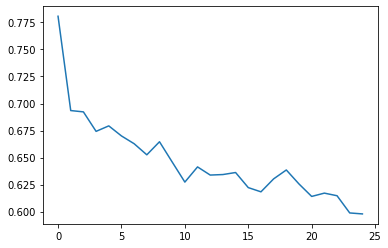

Epoch 1/25
17/17 - 6s - loss: 0.7270 - accuracy: 0.5120 - auc_15: 0.5167 - precision_15: 0.5053 - recall_15: 0.5318 - f1_score: 0.6609 - val_loss: 0.6925 - val_accuracy: 0.4760 - val_auc_15: 0.5662 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.6877 - 6s/epoch - 342ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6889 - accuracy: 0.5139 - auc_15: 0.5574 - precision_15: 0.5109 - recall_15: 0.3521 - f1_score: 0.6609 - val_loss: 0.6879 - val_accuracy: 0.5609 - val_auc_15: 0.5905 - val_precision_15: 0.5489 - val_recall_15: 0.9085 - val_f1_score: 0.6877 - 1s/epoch - 69ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6815 - accuracy: 0.5638 - auc_15: 0.5883 - precision_15: 0.5552 - recall_15: 0.5843 - f1_score: 0.6609 - val_loss: 0.6825 - val_accuracy: 0.5609 - val_auc_15: 0.5913 - val_precision_15: 0.5502 - val_recall_15: 0.8873 - val_f1_score: 0.6877 - 1s/epoch - 67ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6952 - accuracy: 0.5213 - auc_15: 0.5303 - precision_15: 0.5148 - recall_1

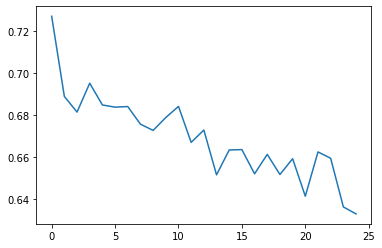

Epoch 1/25
17/17 - 5s - loss: 0.7013 - accuracy: 0.5535 - auc_16: 0.5611 - precision_16: 0.5542 - recall_16: 0.6462 - f1_score: 0.6764 - val_loss: 0.6692 - val_accuracy: 0.6185 - val_auc_16: 0.6524 - val_precision_16: 0.6107 - val_recall_16: 0.6061 - val_f1_score: 0.6567 - 5s/epoch - 304ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6740 - accuracy: 0.6033 - auc_16: 0.6148 - precision_16: 0.6250 - recall_16: 0.5596 - f1_score: 0.6764 - val_loss: 0.6692 - val_accuracy: 0.5926 - val_auc_16: 0.6423 - val_precision_16: 0.5733 - val_recall_16: 0.6515 - val_f1_score: 0.6567 - 1s/epoch - 63ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6756 - accuracy: 0.5978 - auc_16: 0.6191 - precision_16: 0.6000 - recall_16: 0.6390 - f1_score: 0.6764 - val_loss: 0.6788 - val_accuracy: 0.5481 - val_auc_16: 0.6515 - val_precision_16: 0.6667 - val_recall_16: 0.1515 - val_f1_score: 0.6567 - 1s/epoch - 62ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6575 - accuracy: 0.6070 - auc_16: 0.6540 - precision_16: 0.6290 - recall_16: 0.563

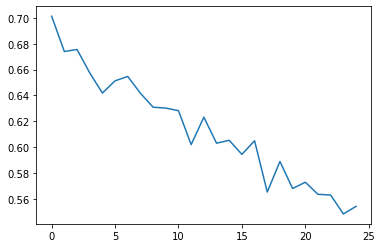

In [37]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [39]:
y_pred = cnnlstm_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_body_model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 66.12% 
ROC/AUC: 0.67 
Precision: 0.90 
Recall: 0.67 
F1 score: 0.91


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

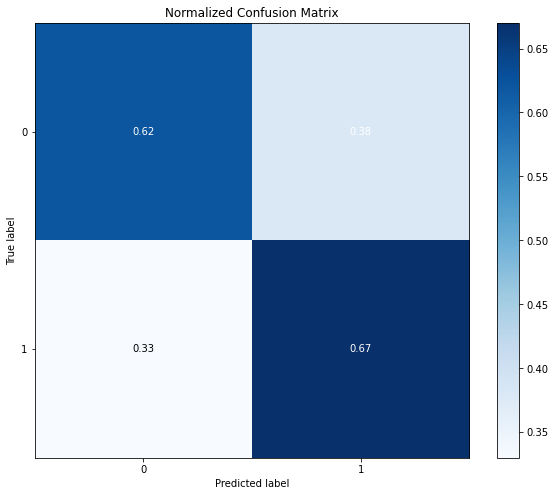

In [40]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10,8))

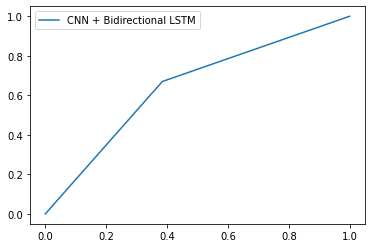

In [41]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

#### RCNN

In [46]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 0.8114 - accuracy: 0.6155 - auc_19: 0.6360 - precision_19: 0.6196 - recall_19: 0.6241 - f1_score: 0.6724 - val_loss: 10.7725 - val_accuracy: 0.4982 - val_auc_19: 0.5000 - val_precision_19: 0.4982 - val_recall_19: 1.0000 - val_f1_score: 0.6650 - 2s/epoch - 132ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6516 - accuracy: 0.6673 - auc_19: 0.7364 - precision_19: 0.6794 - recall_19: 0.6496 - f1_score: 0.6724 - val_loss: 3.7508 - val_accuracy: 0.4982 - val_auc_19: 0.5672 - val_precision_19: 0.4982 - val_recall_19: 1.0000 - val_f1_score: 0.6650 - 733ms/epoch - 43ms/step
Epoch 3/25
17/17 - 1s - loss: 0.5864 - accuracy: 0.6950 - auc_19: 0.7655 - precision_19: 0.6968 - recall_19: 0.7044 - f1_score: 0.6724 - val_loss: 1.5666 - val_accuracy: 0.5351 - val_auc_19: 0.7181 - val_precision_19: 0.5174 - val_recall_19: 0.9926 - val_f1_score: 0.6650 - 702ms/epoch - 41ms/step
Epoch 4/25
17/17 - 1s - loss: 0.5664 - accuracy: 0.7172 - auc_19: 0.7848 - precision_19: 0.7065 - recall_19

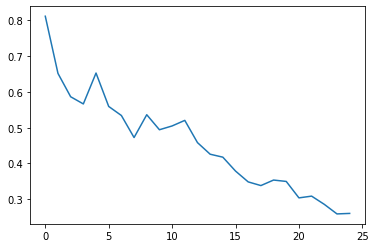

Epoch 1/25
17/17 - 2s - loss: 1.0020 - accuracy: 0.5896 - auc_20: 0.6095 - precision_20: 0.5801 - recall_20: 0.6105 - f1_score: 0.6609 - val_loss: 8.9057 - val_accuracy: 0.5240 - val_auc_20: 0.5000 - val_precision_20: 0.5240 - val_recall_20: 1.0000 - val_f1_score: 0.6877 - 2s/epoch - 146ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6787 - accuracy: 0.6525 - auc_20: 0.7079 - precision_20: 0.6639 - recall_20: 0.5993 - f1_score: 0.6609 - val_loss: 7.2738 - val_accuracy: 0.5240 - val_auc_20: 0.5000 - val_precision_20: 0.5240 - val_recall_20: 1.0000 - val_f1_score: 0.6877 - 784ms/epoch - 46ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6187 - accuracy: 0.6673 - auc_20: 0.7370 - precision_20: 0.6537 - recall_20: 0.6929 - f1_score: 0.6609 - val_loss: 1.7502 - val_accuracy: 0.5055 - val_auc_20: 0.5535 - val_precision_20: 0.6176 - val_recall_20: 0.1479 - val_f1_score: 0.6877 - 793ms/epoch - 47ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6210 - accuracy: 0.6728 - auc_20: 0.7391 - precision_20: 0.6731 - recall_20:

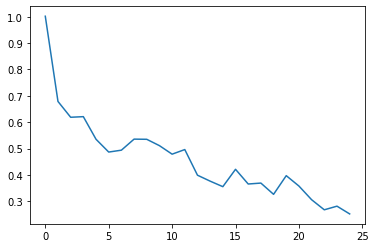

Epoch 1/25
17/17 - 2s - loss: 1.1085 - accuracy: 0.6015 - auc_21: 0.6194 - precision_21: 0.6034 - recall_21: 0.6426 - f1_score: 0.6764 - val_loss: 2.5009 - val_accuracy: 0.5333 - val_auc_21: 0.5507 - val_precision_21: 0.6000 - val_recall_21: 0.1364 - val_f1_score: 0.6567 - 2s/epoch - 128ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6307 - accuracy: 0.6771 - auc_21: 0.7257 - precision_21: 0.7024 - recall_21: 0.6390 - f1_score: 0.6764 - val_loss: 3.9379 - val_accuracy: 0.4889 - val_auc_21: 0.5754 - val_precision_21: 0.4889 - val_recall_21: 1.0000 - val_f1_score: 0.6567 - 747ms/epoch - 44ms/step
Epoch 3/25
17/17 - 1s - loss: 0.5935 - accuracy: 0.6734 - auc_21: 0.7475 - precision_21: 0.6689 - recall_21: 0.7148 - f1_score: 0.6764 - val_loss: 1.6642 - val_accuracy: 0.5333 - val_auc_21: 0.6335 - val_precision_21: 0.5117 - val_recall_21: 0.9924 - val_f1_score: 0.6567 - 734ms/epoch - 43ms/step
Epoch 4/25
17/17 - 1s - loss: 0.5347 - accuracy: 0.7362 - auc_21: 0.8035 - precision_21: 0.7538 - recall_21:

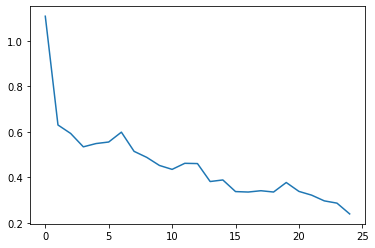

In [47]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [48]:
y_pred = rcnn_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_body_model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 53.88% 
ROC/AUC: 0.62 
Precision: 0.88 
Recall: 0.52 
F1 score: 0.91


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

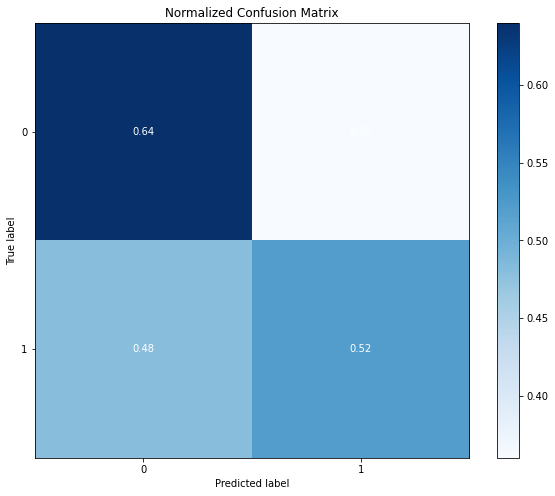

In [50]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10, 8))

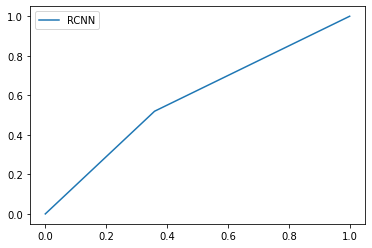

In [51]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

### Multiclass Classification

#### Dataset

In [134]:
X_train, X_test, y_train, y_test = load_dataset('skeleton')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(812, 1, 350, 35) (812, 7)
(245, 1, 350, 35) (245, 7)


In [135]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [136]:
classes = get_class_names('skeleton')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain               403
LowerBody Mild        164
LowerBody Moderate    103
UpperBody Mild         75
UpperBody Moderate     64
UpperBody Severe        2
LowerBody Severe        1
dtype: int64

In [137]:
nopain, lbmild, lbmod, ubmild, ubmod, ubsevere, lbsevere = np.sum(y, axis=0)
total = nopain + ubmild + lbmod + lbmild + ubmod + ubsevere + lbsevere

weight_for_lbmild = (1 / lbmild) * (total / 2.0)
weight_for_lbmod = (1 / lbmod) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_ubmild = (1 / ubmild) * (total / 2.0)
weight_for_ubmod = (1 / ubmod) * (total / 2.0)
weight_for_lbsevere = (1 / lbsevere) * (total / 2.0)
weight_for_ubsevere = (1 / ubsevere) * (total / 2.0)

class_weight = {0: weight_for_nopain, 1: weight_for_lbmild, 2: weight_for_lbmod, 3: weight_for_ubmild, 4: weight_for_ubmod, 5: weight_for_ubsevere, 6: weight_for_lbsevere}

print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lbmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lbmod))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_ubmild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_ubmod))
print('Weight for class "Upper Body Severe Pain": {:.2f}'.format(weight_for_ubsevere))
print('Weight for class "Lower Body Severe Pain": {:.2f}'.format(weight_for_lbsevere))

Weight for class "No Pain": 2.48
Weight for class "Lower Body Mild Pain": 3.94
Weight for class "Lower Body Moderate Pain": 406.00
Weight for class "Upper Body Mild Pain": 1.01
Weight for class "Upper Body Moderate Pain": 5.41
Weight for class "Upper Body Severe Pain": 6.34
Weight for class "Lower Body Severe Pain": 203.00


#### CNN + Bidirectional LSTM

In [138]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(512, activation='relu'))(flatten)
        dense = Dense(512, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 42s - loss: 708.0490 - accuracy: 0.1978 - auc_55: 0.5363 - precision_55: 0.1978 - recall_55: 0.1978 - f1_score: 0.1229 - val_loss: 41.5096 - val_accuracy: 0.5018 - val_auc_55: 0.7094 - val_precision_55: 0.5018 - val_recall_55: 0.5018 - val_f1_score: 0.0955 - 42s/epoch - 2s/step
Epoch 2/25
17/17 - 34s - loss: 400.6503 - accuracy: 0.2181 - auc_55: 0.5437 - precision_55: 0.2181 - recall_55: 0.2181 - f1_score: 0.1403 - val_loss: 104.3955 - val_accuracy: 0.0886 - val_auc_55: 0.4616 - val_precision_55: 0.0886 - val_recall_55: 0.0886 - val_f1_score: 0.0242 - 34s/epoch - 2s/step
Epoch 3/25
17/17 - 34s - loss: 182.0925 - accuracy: 0.1682 - auc_55: 0.5169 - precision_55: 0.1682 - recall_55: 0.1682 - f1_score: 0.1062 - val_loss: 124.2839 - val_accuracy: 0.0295 - val_auc_55: 0.4271 - val_precision_55: 0.0295 - val_recall_55: 0.0295 - val_f1_score: 0.0212 - 34s/epoch - 2s/step
Epoch 4/25
17/17 - 33s - loss: 201.8052 - accuracy: 0.1553 - auc_55: 0.5030 - precision_55: 0.1556 - rec

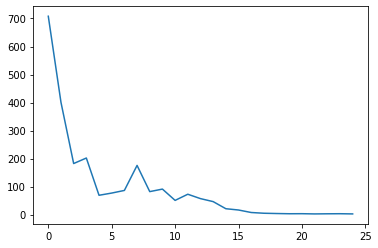

Epoch 1/25
17/17 - 45s - loss: 854.1895 - accuracy: 0.1904 - auc_56: 0.5263 - precision_56: 0.1904 - recall_56: 0.1904 - f1_score: 0.1204 - val_loss: 333.5464 - val_accuracy: 0.0000e+00 - val_auc_56: 0.4167 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00 - val_f1_score: 0.0000e+00 - 45s/epoch - 3s/step
Epoch 2/25
17/17 - 37s - loss: 814.8884 - accuracy: 0.0462 - auc_56: 0.4391 - precision_56: 0.0444 - recall_56: 0.0444 - f1_score: 0.0487 - val_loss: 106.6300 - val_accuracy: 0.2177 - val_auc_56: 0.5305 - val_precision_56: 0.2210 - val_recall_56: 0.2177 - val_f1_score: 0.0874 - 37s/epoch - 2s/step
Epoch 3/25
17/17 - 34s - loss: 626.5685 - accuracy: 0.2366 - auc_56: 0.5671 - precision_56: 0.2375 - recall_56: 0.2366 - f1_score: 0.1334 - val_loss: 79.0381 - val_accuracy: 0.1845 - val_auc_56: 0.5424 - val_precision_56: 0.1845 - val_recall_56: 0.1845 - val_f1_score: 0.0626 - 34s/epoch - 2s/step
Epoch 4/25
17/17 - 34s - loss: 223.0693 - accuracy: 0.2440 - auc_56: 0.5692 - precision_

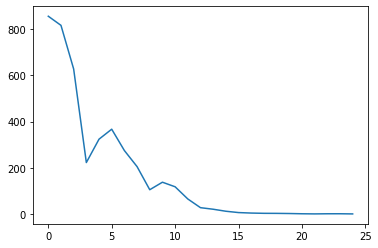

Epoch 1/25
17/17 - 42s - loss: 1066.3601 - accuracy: 0.1421 - auc_57: 0.4982 - precision_57: 0.1421 - recall_57: 0.1421 - f1_score: 0.1094 - val_loss: 240.4742 - val_accuracy: 0.1333 - val_auc_57: 0.5019 - val_precision_57: 0.1333 - val_recall_57: 0.1333 - val_f1_score: 0.0565 - 42s/epoch - 2s/step
Epoch 2/25
17/17 - 46s - loss: 1609.8722 - accuracy: 0.2085 - auc_57: 0.5369 - precision_57: 0.2085 - recall_57: 0.2085 - f1_score: 0.0901 - val_loss: 239.2273 - val_accuracy: 0.0852 - val_auc_57: 0.4664 - val_precision_57: 0.0852 - val_recall_57: 0.0852 - val_f1_score: 0.0224 - 46s/epoch - 3s/step
Epoch 3/25
17/17 - 41s - loss: 734.2584 - accuracy: 0.1753 - auc_57: 0.5225 - precision_57: 0.1753 - recall_57: 0.1753 - f1_score: 0.1043 - val_loss: 214.2170 - val_accuracy: 0.0296 - val_auc_57: 0.4226 - val_precision_57: 0.0297 - val_recall_57: 0.0296 - val_f1_score: 0.0159 - 41s/epoch - 2s/step
Epoch 4/25
17/17 - 35s - loss: 546.3088 - accuracy: 0.0849 - auc_57: 0.4616 - precision_57: 0.0849 - 

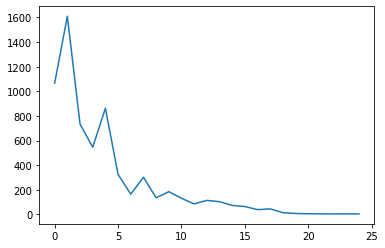

In [139]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on holdout set

In [122]:
y_pred = cnnlstm_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 13.45% 
Balanced Accuracy: 11.62% 
ROC/AUC: 0.49 
Precision: 0.13 
Recall: 0.13 
F1 score: 0.09


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

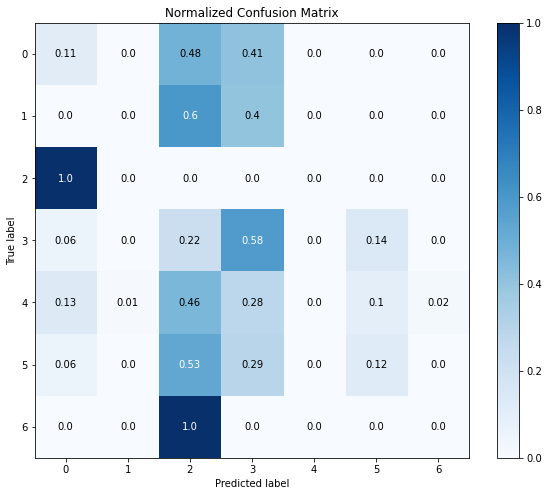

In [123]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

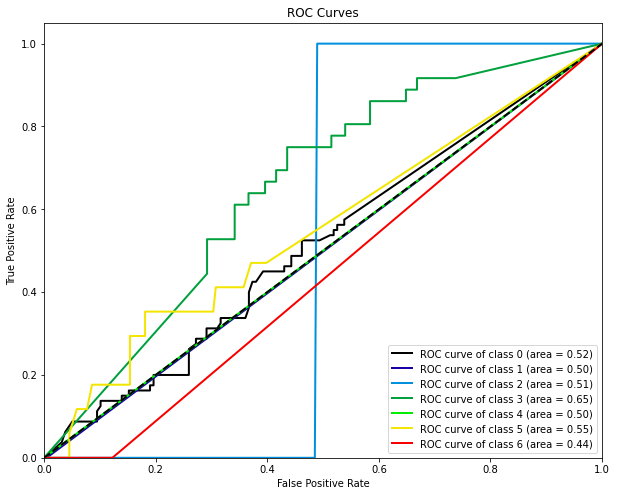

In [124]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

#### RCNN

In [101]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 19.0587 - accuracy: 0.3148 - auc_52: 0.6288 - precision_52: 0.2434 - recall_52: 0.1056 - f1_score: 0.1651 - val_loss: 2.3713 - val_accuracy: 0.0077 - val_auc_52: 0.6212 - val_precision_52: 0.1818 - val_recall_52: 0.0077 - val_f1_score: 0.0174 - 3s/epoch - 154ms/step
Epoch 2/25
17/17 - 1s - loss: 11.5975 - accuracy: 0.0864 - auc_52: 0.5630 - precision_52: 0.0881 - recall_52: 0.0326 - f1_score: 0.0759 - val_loss: 2.9461 - val_accuracy: 0.1533 - val_auc_52: 0.5056 - val_precision_52: 0.1818 - val_recall_52: 0.0077 - val_f1_score: 0.0674 - 737ms/epoch - 43ms/step
Epoch 3/25
17/17 - 1s - loss: 8.9171 - accuracy: 0.2303 - auc_52: 0.6606 - precision_52: 0.2519 - recall_52: 0.0653 - f1_score: 0.1659 - val_loss: 3.2977 - val_accuracy: 0.1379 - val_auc_52: 0.6856 - val_precision_52: 0.1818 - val_recall_52: 0.0077 - val_f1_score: 0.0383 - 880ms/epoch - 52ms/step
Epoch 4/25
17/17 - 1s - loss: 7.3447 - accuracy: 0.1823 - auc_52: 0.6122 - precision_52: 0.0854 - recall_5

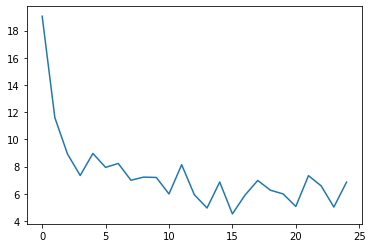

Epoch 1/25
17/17 - 2s - loss: 7.6432 - accuracy: 0.0614 - auc_53: 0.5550 - precision_53: 0.1152 - recall_53: 0.0365 - f1_score: 0.0502 - val_loss: 2.8256 - val_accuracy: 0.4636 - val_auc_53: 0.7602 - val_precision_53: 0.2500 - val_recall_53: 0.0038 - val_f1_score: 0.0989 - 2s/epoch - 120ms/step
Epoch 2/25
17/17 - 1s - loss: 9.7991 - accuracy: 0.2073 - auc_53: 0.6924 - precision_53: 0.3396 - recall_53: 0.0691 - f1_score: 0.1109 - val_loss: 3.0582 - val_accuracy: 0.0881 - val_auc_53: 0.7106 - val_precision_53: 0.2500 - val_recall_53: 0.0038 - val_f1_score: 0.0247 - 656ms/epoch - 39ms/step
Epoch 3/25
17/17 - 1s - loss: 6.3274 - accuracy: 0.1862 - auc_53: 0.6797 - precision_53: 0.3082 - recall_53: 0.0864 - f1_score: 0.1125 - val_loss: 2.2646 - val_accuracy: 0.1188 - val_auc_53: 0.5384 - val_precision_53: 0.5000 - val_recall_53: 0.0077 - val_f1_score: 0.0404 - 687ms/epoch - 40ms/step
Epoch 4/25
17/17 - 1s - loss: 5.1087 - accuracy: 0.1420 - auc_53: 0.6064 - precision_53: 0.2805 - recall_53:

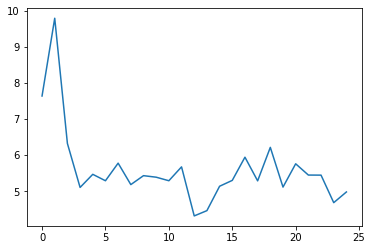

Epoch 1/25
17/17 - 2s - loss: 18.9327 - accuracy: 0.1513 - auc_54: 0.6267 - precision_54: 0.2086 - recall_54: 0.0556 - f1_score: 0.0930 - val_loss: 2.5159 - val_accuracy: 0.0731 - val_auc_54: 0.5819 - val_precision_54: 0.4000 - val_recall_54: 0.0077 - val_f1_score: 0.0208 - 2s/epoch - 125ms/step
Epoch 2/25
17/17 - 1s - loss: 10.0044 - accuracy: 0.1571 - auc_54: 0.6182 - precision_54: 0.2688 - recall_54: 0.0479 - f1_score: 0.0982 - val_loss: 2.2200 - val_accuracy: 0.1077 - val_auc_54: 0.6196 - val_precision_54: 0.4000 - val_recall_54: 0.0077 - val_f1_score: 0.0305 - 706ms/epoch - 42ms/step
Epoch 3/25
17/17 - 1s - loss: 9.8459 - accuracy: 0.1456 - auc_54: 0.6020 - precision_54: 0.1491 - recall_54: 0.0460 - f1_score: 0.1112 - val_loss: 1.9356 - val_accuracy: 0.2000 - val_auc_54: 0.5954 - val_precision_54: 0.6000 - val_recall_54: 0.0115 - val_f1_score: 0.0524 - 685ms/epoch - 40ms/step
Epoch 4/25
17/17 - 1s - loss: 9.2444 - accuracy: 0.3161 - auc_54: 0.6859 - precision_54: 0.4034 - recall_5

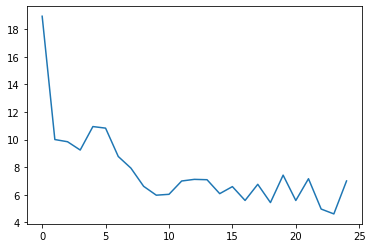

In [125]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [129]:
y_pred = rcnn_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 33.61% 
Balanced Accuracy: 14.50% 
ROC/AUC: 0.67 
Precision: 0.07 
Recall: 0.00 
F1 score: 0.08


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

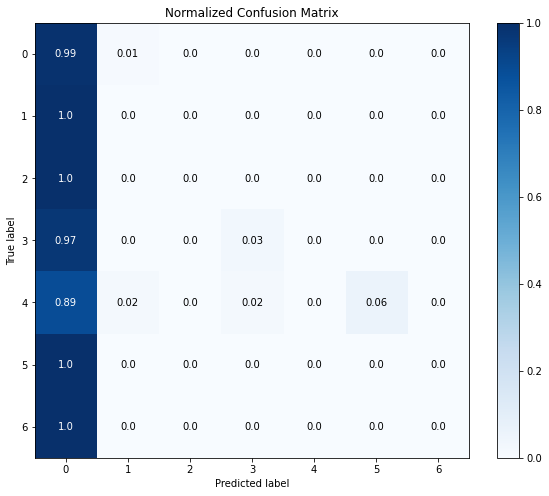

In [130]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

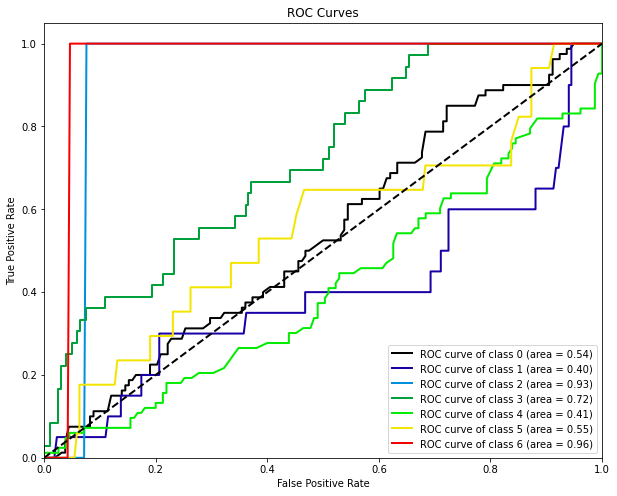

In [131]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

## 2. Unimodal Face Modality (Action Units + Head Pose)

### Binary Classification

#### Dataset

In [52]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


In [53]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### CNN + Bidirectional LSTM

In [54]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 4s - loss: 13679.8789 - accuracy: 0.5202 - auc_22: 0.5115 - precision_22: 0.5222 - recall_22: 0.7068 - f1_score: 0.6696 - val_loss: 15796.4717 - val_accuracy: 0.4981 - val_auc_22: 0.5035 - val_precision_22: 0.4961 - val_recall_22: 0.9767 - val_f1_score: 0.6580 - 4s/epoch - 228ms/step
Epoch 2/25
17/17 - 1s - loss: 8436.9766 - accuracy: 0.4856 - auc_22: 0.4853 - precision_22: 0.4969 - recall_22: 0.6090 - f1_score: 0.5977 - val_loss: 2071.1589 - val_accuracy: 0.5096 - val_auc_22: 0.5151 - val_precision_22: 0.5020 - val_recall_22: 0.9922 - val_f1_score: 0.6667 - 867ms/epoch - 51ms/step
Epoch 3/25
17/17 - 1s - loss: 20166.5059 - accuracy: 0.5029 - auc_22: 0.4912 - precision_22: 0.5069 - recall_22: 0.9624 - f1_score: 0.6709 - val_loss: 996.1554 - val_accuracy: 0.4751 - val_auc_22: 0.4621 - val_precision_22: 0.4661 - val_recall_22: 0.4264 - val_f1_score: 0.5472 - 1s/epoch - 60ms/step
Epoch 4/25
17/17 - 1s - loss: 10472.0020 - accuracy: 0.4184 - auc_22: 0.4252 - precision_22

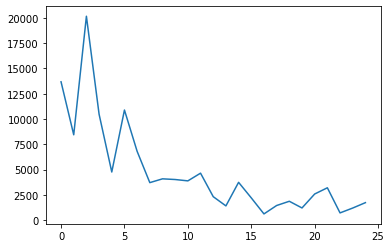

Epoch 1/25
17/17 - 4s - loss: 6616.7090 - accuracy: 0.5029 - auc_23: 0.5079 - precision_23: 0.4981 - recall_23: 0.5039 - f1_score: 0.5709 - val_loss: 14460.6973 - val_accuracy: 0.4751 - val_auc_23: 0.4996 - val_precision_23: 0.5000 - val_recall_23: 0.0073 - val_f1_score: 0.0144 - 4s/epoch - 255ms/step
Epoch 2/25
17/17 - 1s - loss: 27563.7246 - accuracy: 0.5067 - auc_23: 0.5019 - precision_23: 1.0000 - recall_23: 0.0039 - f1_score: 0.0305 - val_loss: 7348.5518 - val_accuracy: 0.4751 - val_auc_23: 0.4974 - val_precision_23: 0.5000 - val_recall_23: 0.0292 - val_f1_score: 0.3037 - 976ms/epoch - 57ms/step
Epoch 3/25
17/17 - 1s - loss: 7277.1733 - accuracy: 0.5182 - auc_23: 0.5143 - precision_23: 0.5106 - recall_23: 0.6550 - f1_score: 0.6499 - val_loss: 3721.0437 - val_accuracy: 0.4713 - val_auc_23: 0.4977 - val_precision_23: 0.4848 - val_recall_23: 0.1168 - val_f1_score: 0.6667 - 888ms/epoch - 52ms/step
Epoch 4/25
17/17 - 1s - loss: 6327.3511 - accuracy: 0.5202 - auc_23: 0.5282 - precision_

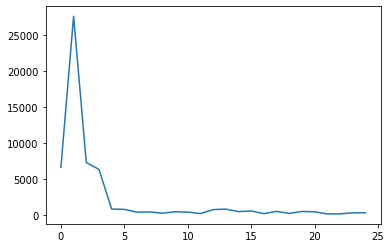

Epoch 1/25
17/17 - 4s - loss: 7732.3994 - accuracy: 0.5000 - auc_24: 0.4954 - precision_24: 0.5062 - recall_24: 0.7632 - f1_score: 0.6344 - val_loss: 8373.4414 - val_accuracy: 0.3962 - val_auc_24: 0.3906 - val_precision_24: 0.3814 - val_recall_24: 0.3488 - val_f1_score: 0.3710 - 4s/epoch - 223ms/step
Epoch 2/25
17/17 - 1s - loss: 3111.5488 - accuracy: 0.5077 - auc_24: 0.4991 - precision_24: 0.5091 - recall_24: 0.9436 - f1_score: 0.6614 - val_loss: 24046.3301 - val_accuracy: 0.5000 - val_auc_24: 0.5038 - val_precision_24: 0.4981 - val_recall_24: 1.0000 - val_f1_score: 0.6649 - 762ms/epoch - 45ms/step
Epoch 3/25
17/17 - 1s - loss: 1992.4786 - accuracy: 0.5192 - auc_24: 0.5098 - precision_24: 0.5146 - recall_24: 0.9962 - f1_score: 0.6794 - val_loss: 16373.7344 - val_accuracy: 0.4500 - val_auc_24: 0.4180 - val_precision_24: 0.4685 - val_recall_24: 0.8062 - val_f1_score: 0.6474 - 743ms/epoch - 44ms/step
Epoch 4/25
17/17 - 1s - loss: 1310.7302 - accuracy: 0.4521 - auc_24: 0.4463 - precision_

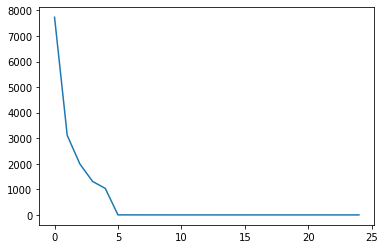

In [55]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [56]:
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 52.10% 
ROC/AUC: 0.45 
Precision: 0.85 
Recall: 0.52 
F1 score: 0.90


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

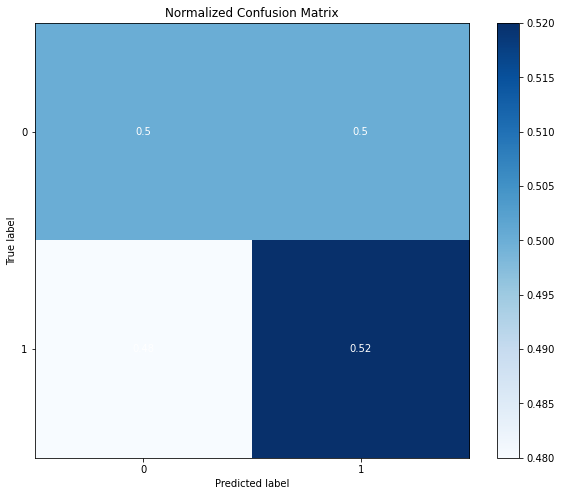

In [57]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10, 8))

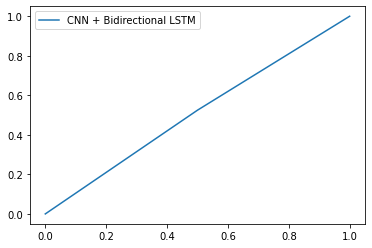

In [58]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

#### RCNN

In [59]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 1.4964 - accuracy: 0.5528 - auc_25: 0.5692 - precision_25: 0.5498 - recall_25: 0.6842 - f1_score: 0.6743 - val_loss: 0.7624 - val_accuracy: 0.5364 - val_auc_25: 0.5875 - val_precision_25: 0.5179 - val_recall_25: 0.8992 - val_f1_score: 0.6615 - 2s/epoch - 129ms/step
Epoch 2/25
17/17 - 1s - loss: 0.9819 - accuracy: 0.5432 - auc_25: 0.5682 - precision_25: 0.5543 - recall_25: 0.5376 - f1_score: 0.6760 - val_loss: 0.6745 - val_accuracy: 0.5057 - val_auc_25: 0.5395 - val_precision_25: 0.5000 - val_recall_25: 0.9690 - val_f1_score: 0.6615 - 719ms/epoch - 42ms/step
Epoch 3/25
17/17 - 1s - loss: 0.8326 - accuracy: 0.5048 - auc_25: 0.5177 - precision_25: 0.5171 - recall_25: 0.4549 - f1_score: 0.6760 - val_loss: 0.7590 - val_accuracy: 0.5057 - val_auc_25: 0.5265 - val_precision_25: 0.5000 - val_recall_25: 1.0000 - val_f1_score: 0.6615 - 799ms/epoch - 47ms/step
Epoch 4/25
17/17 - 1s - loss: 0.7821 - accuracy: 0.5758 - auc_25: 0.6105 - precision_25: 0.5733 - recall_25:

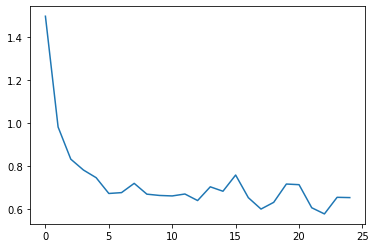

Epoch 1/25
17/17 - 2s - loss: 1.1414 - accuracy: 0.5393 - auc_26: 0.5518 - precision_26: 0.5294 - recall_26: 0.6279 - f1_score: 0.6624 - val_loss: 0.6995 - val_accuracy: 0.5211 - val_auc_26: 0.6195 - val_precision_26: 0.5231 - val_recall_26: 0.9927 - val_f1_score: 0.6884 - 2s/epoch - 125ms/step
Epoch 2/25
17/17 - 1s - loss: 0.8615 - accuracy: 0.5509 - auc_26: 0.6045 - precision_26: 0.5316 - recall_26: 0.7829 - f1_score: 0.6624 - val_loss: 0.7765 - val_accuracy: 0.5249 - val_auc_26: 0.5004 - val_precision_26: 0.5251 - val_recall_26: 0.9927 - val_f1_score: 0.6884 - 716ms/epoch - 42ms/step
Epoch 3/25
17/17 - 1s - loss: 0.8469 - accuracy: 0.4952 - auc_26: 0.5225 - precision_26: 0.4901 - recall_26: 0.4806 - f1_score: 0.6624 - val_loss: 0.8136 - val_accuracy: 0.4789 - val_auc_26: 0.5004 - val_precision_26: 1.0000 - val_recall_26: 0.0073 - val_f1_score: 0.6884 - 736ms/epoch - 43ms/step
Epoch 4/25
17/17 - 1s - loss: 0.8459 - accuracy: 0.5259 - auc_26: 0.5607 - precision_26: 0.5184 - recall_26:

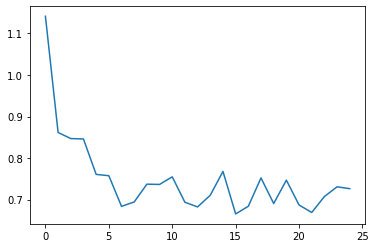

Epoch 1/25
17/17 - 2s - loss: 1.1844 - accuracy: 0.5287 - auc_27: 0.5540 - precision_27: 0.5714 - recall_27: 0.3008 - f1_score: 0.6751 - val_loss: 1.0809 - val_accuracy: 0.5038 - val_auc_27: 0.5336 - val_precision_27: 0.5000 - val_recall_27: 0.9922 - val_f1_score: 0.6649 - 2s/epoch - 112ms/step
Epoch 2/25
17/17 - 1s - loss: 1.0375 - accuracy: 0.5192 - auc_27: 0.5398 - precision_27: 0.5151 - recall_27: 0.9624 - f1_score: 0.6777 - val_loss: 1.0157 - val_accuracy: 0.5000 - val_auc_27: 0.5140 - val_precision_27: 0.4981 - val_recall_27: 1.0000 - val_f1_score: 0.6649 - 654ms/epoch - 38ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7748 - accuracy: 0.5307 - auc_27: 0.5842 - precision_27: 0.5277 - recall_27: 0.7519 - f1_score: 0.6777 - val_loss: 1.1882 - val_accuracy: 0.5000 - val_auc_27: 0.4962 - val_precision_27: 0.4981 - val_recall_27: 1.0000 - val_f1_score: 0.6632 - 642ms/epoch - 38ms/step
Epoch 4/25
17/17 - 1s - loss: 0.8267 - accuracy: 0.5307 - auc_27: 0.5524 - precision_27: 0.5327 - recall_27:

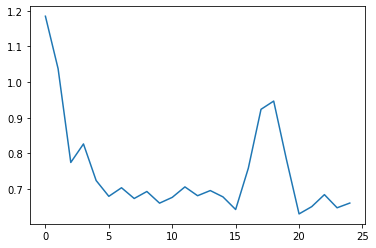

In [60]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Evaluation on the holdout set

In [61]:
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 84.45% 
ROC/AUC: 0.61 
Precision: 0.85 
Recall: 0.99 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

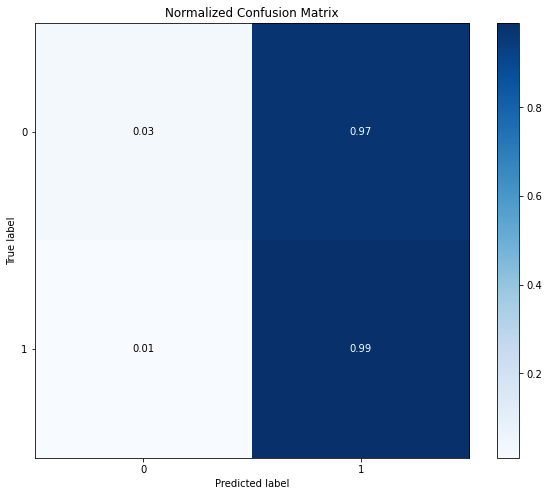

In [62]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10,8))

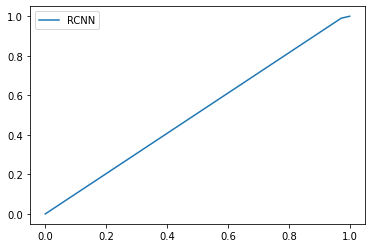

In [63]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

### Multiclass Classification

#### Dataset

In [141]:
X_train, X_test, y_train, y_test = load_dataset('AUs')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(782, 1, 350, 25) (782, 7)
(238, 1, 350, 25) (238, 7)


In [142]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [143]:
classes = get_class_names('AUs')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain               387
LowerBody Mild        157
LowerBody Moderate    100
UpperBody Mild         74
UpperBody Moderate     61
UpperBody Severe        2
LowerBody Severe        1
dtype: int64

In [144]:
nopain, lbmild, lbmod, ubmild, ubmod, ubsevere, lbsevere = np.sum(y, axis=0)
total = nopain + ubmild + lbmod + lbmild + ubmod + ubsevere + lbsevere

weight_for_lbmild = (1 / lbmild) * (total / 2.0)
weight_for_lbmod = (1 / lbmod) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_ubmild = (1 / ubmild) * (total / 2.0)
weight_for_ubmod = (1 / ubmod) * (total / 2.0)
weight_for_lbsevere = (1 / lbsevere) * (total / 2.0)
weight_for_ubsevere = (1 / ubsevere) * (total / 2.0)

class_weight = {0: weight_for_nopain, 1: weight_for_lbmild, 2: weight_for_lbmod, 3: weight_for_ubmild, 4: weight_for_ubmod, 5: weight_for_ubsevere, 6: weight_for_lbsevere}

print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lbmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lbmod))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_ubmild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_ubmod))
print('Weight for class "Upper Body Severe Pain": {:.2f}'.format(weight_for_ubsevere))
print('Weight for class "Lower Body Severe Pain": {:.2f}'.format(weight_for_lbsevere))

Weight for class "No Pain": 2.49
Weight for class "Lower Body Mild Pain": 3.91
Weight for class "Lower Body Moderate Pain": 391.00
Weight for class "Upper Body Mild Pain": 1.01
Weight for class "Upper Body Moderate Pain": 5.28
Weight for class "Upper Body Severe Pain": 6.41
Weight for class "Lower Body Severe Pain": 195.50


#### CNN + Bidirectional LSTM

In [145]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(512, activation='relu'))(flatten)
        dense = Dense(512, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 43s - loss: 709009.5625 - accuracy: 0.1651 - auc_58: 0.5126 - precision_58: 0.1651 - recall_58: 0.1651 - f1_score: 0.0956 - val_loss: 370049.1875 - val_accuracy: 0.0920 - val_auc_58: 0.4703 - val_precision_58: 0.0920 - val_recall_58: 0.0920 - val_f1_score: 0.0279 - 43s/epoch - 3s/step
Epoch 2/25
17/17 - 35s - loss: 416672.4062 - accuracy: 0.1132 - auc_58: 0.4827 - precision_58: 0.1132 - recall_58: 0.1132 - f1_score: 0.0561 - val_loss: 223351.9375 - val_accuracy: 0.0805 - val_auc_58: 0.4636 - val_precision_58: 0.0805 - val_recall_58: 0.0805 - val_f1_score: 0.0253 - 35s/epoch - 2s/step
Epoch 3/25
17/17 - 35s - loss: 610326.4375 - accuracy: 0.3186 - auc_58: 0.6077 - precision_58: 0.3186 - recall_58: 0.3186 - f1_score: 0.1367 - val_loss: 182735.7031 - val_accuracy: 0.4674 - val_auc_58: 0.6937 - val_precision_58: 0.4674 - val_recall_58: 0.4674 - val_f1_score: 0.1235 - 35s/epoch - 2s/step
Epoch 4/25
17/17 - 32s - loss: 404234.6875 - accuracy: 0.1881 - auc_58: 0.5264 - prec

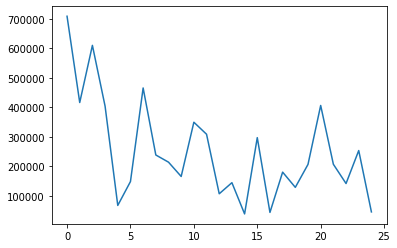

Epoch 1/25
17/17 - 40s - loss: 404246.3438 - accuracy: 0.1804 - auc_59: 0.5260 - precision_59: 0.1804 - recall_59: 0.1804 - f1_score: 0.1048 - val_loss: 118395.2188 - val_accuracy: 0.2069 - val_auc_59: 0.5374 - val_precision_59: 0.2069 - val_recall_59: 0.2069 - val_f1_score: 0.0507 - 40s/epoch - 2s/step
Epoch 2/25
17/17 - 34s - loss: 286745.1250 - accuracy: 0.1497 - auc_59: 0.5040 - precision_59: 0.1497 - recall_59: 0.1497 - f1_score: 0.0829 - val_loss: 160392.5781 - val_accuracy: 0.0881 - val_auc_59: 0.4681 - val_precision_59: 0.0881 - val_recall_59: 0.0881 - val_f1_score: 0.0247 - 34s/epoch - 2s/step
Epoch 3/25
17/17 - 32s - loss: 434831.5625 - accuracy: 0.1555 - auc_59: 0.5081 - precision_59: 0.1555 - recall_59: 0.1555 - f1_score: 0.0668 - val_loss: 85417.8984 - val_accuracy: 0.1686 - val_auc_59: 0.5131 - val_precision_59: 0.1686 - val_recall_59: 0.1686 - val_f1_score: 0.0767 - 32s/epoch - 2s/step
Epoch 4/25
17/17 - 30s - loss: 328337.6562 - accuracy: 0.2265 - auc_59: 0.5493 - preci

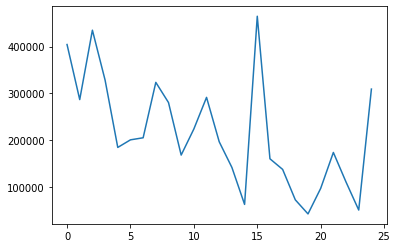

Epoch 1/25
17/17 - 49s - loss: 332946.1250 - accuracy: 0.2088 - auc_60: 0.5384 - precision_60: 0.2088 - recall_60: 0.2088 - f1_score: 0.1383 - val_loss: 141284.5156 - val_accuracy: 0.1423 - val_auc_60: 0.4997 - val_precision_60: 0.1423 - val_recall_60: 0.1423 - val_f1_score: 0.0385 - 49s/epoch - 3s/step
Epoch 2/25
17/17 - 34s - loss: 1877616.5000 - accuracy: 0.1418 - auc_60: 0.4994 - precision_60: 0.1418 - recall_60: 0.1418 - f1_score: 0.0470 - val_loss: 88009.9297 - val_accuracy: 0.4962 - val_auc_60: 0.7061 - val_precision_60: 0.4962 - val_recall_60: 0.4962 - val_f1_score: 0.0950 - 34s/epoch - 2s/step
Epoch 3/25
17/17 - 31s - loss: 532930.0000 - accuracy: 0.1552 - auc_60: 0.5072 - precision_60: 0.1552 - recall_60: 0.1552 - f1_score: 0.0632 - val_loss: 146214.9219 - val_accuracy: 0.1077 - val_auc_60: 0.4773 - val_precision_60: 0.1077 - val_recall_60: 0.1077 - val_f1_score: 0.0541 - 31s/epoch - 2s/step
Epoch 4/25
17/17 - 32s - loss: 799640.6250 - accuracy: 0.1226 - auc_60: 0.4879 - prec

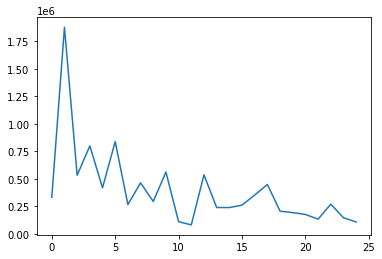

In [146]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [112]:
y_pred = cnnlstm_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_face_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 12.61% 
Balanced Accuracy: 13.52% 
ROC/AUC: 0.49 
Precision: 0.13 
Recall: 0.13 
F1 score: 0.06


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

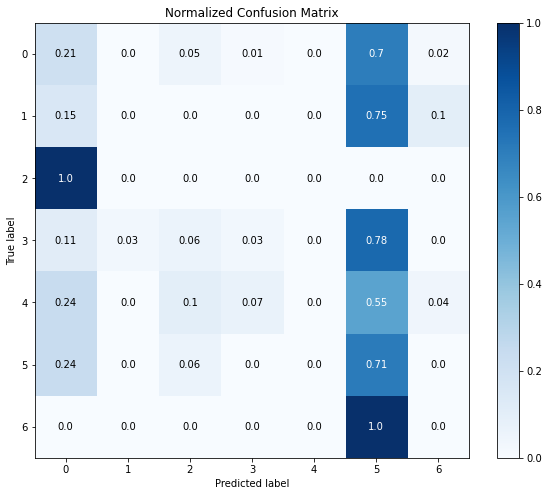

In [113]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

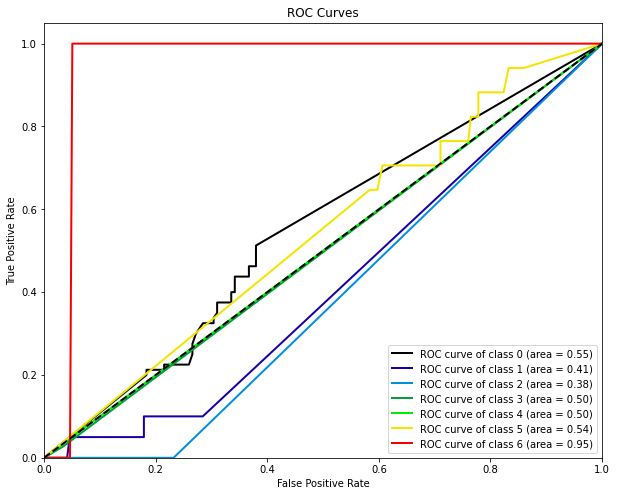

In [114]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

#### RCNN

In [115]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 12.4345 - accuracy: 0.1286 - auc_46: 0.5057 - precision_46: 0.0895 - recall_46: 0.0326 - f1_score: 0.0884 - val_loss: 3.2826 - val_accuracy: 0.0958 - val_auc_46: 0.6645 - val_precision_46: 0.4545 - val_recall_46: 0.0192 - val_f1_score: 0.0302 - 3s/epoch - 147ms/step
Epoch 2/25
17/17 - 1s - loss: 9.0755 - accuracy: 0.2111 - auc_46: 0.6348 - precision_46: 0.3171 - recall_46: 0.0998 - f1_score: 0.1299 - val_loss: 3.1756 - val_accuracy: 0.0115 - val_auc_46: 0.3710 - val_precision_46: 0.2727 - val_recall_46: 0.0115 - val_f1_score: 0.0063 - 795ms/epoch - 47ms/step
Epoch 3/25
17/17 - 1s - loss: 12.8063 - accuracy: 0.0902 - auc_46: 0.5265 - precision_46: 0.1333 - recall_46: 0.0345 - f1_score: 0.0806 - val_loss: 3.4934 - val_accuracy: 0.0115 - val_auc_46: 0.3455 - val_precision_46: 0.2727 - val_recall_46: 0.0115 - val_f1_score: 0.0063 - 775ms/epoch - 46ms/step
Epoch 4/25
17/17 - 1s - loss: 11.2483 - accuracy: 0.2246 - auc_46: 0.6097 - precision_46: 0.3371 - recall_

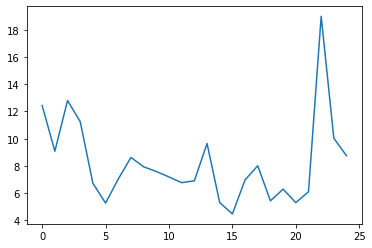

Epoch 1/25
17/17 - 2s - loss: 12.2857 - accuracy: 0.1420 - auc_47: 0.5558 - precision_47: 0.2391 - recall_47: 0.0633 - f1_score: 0.1046 - val_loss: 3.5689 - val_accuracy: 0.4751 - val_auc_47: 0.7778 - val_precision_47: 0.2500 - val_recall_47: 0.0038 - val_f1_score: 0.0927 - 2s/epoch - 122ms/step
Epoch 2/25
17/17 - 1s - loss: 6.2925 - accuracy: 0.2591 - auc_47: 0.6715 - precision_47: 0.2473 - recall_47: 0.0864 - f1_score: 0.1382 - val_loss: 2.5357 - val_accuracy: 0.1111 - val_auc_47: 0.6274 - val_precision_47: 0.2500 - val_recall_47: 0.0038 - val_f1_score: 0.0301 - 649ms/epoch - 38ms/step
Epoch 3/25
17/17 - 1s - loss: 5.2835 - accuracy: 0.2284 - auc_47: 0.7112 - precision_47: 0.4200 - recall_47: 0.1209 - f1_score: 0.2336 - val_loss: 2.5277 - val_accuracy: 0.0881 - val_auc_47: 0.5324 - val_precision_47: 0.2500 - val_recall_47: 0.0038 - val_f1_score: 0.0248 - 634ms/epoch - 37ms/step
Epoch 4/25
17/17 - 1s - loss: 6.5481 - accuracy: 0.1747 - auc_47: 0.6168 - precision_47: 0.2459 - recall_47

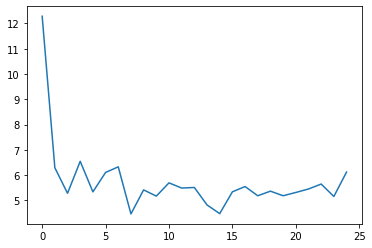

Epoch 1/25
17/17 - 2s - loss: 15.3073 - accuracy: 0.1226 - auc_48: 0.5894 - precision_48: 0.1157 - recall_48: 0.0268 - f1_score: 0.0736 - val_loss: 3.3589 - val_accuracy: 0.0885 - val_auc_48: 0.5827 - val_precision_48: 0.2000 - val_recall_48: 0.0038 - val_f1_score: 0.0322 - 2s/epoch - 115ms/step
Epoch 2/25
17/17 - 1s - loss: 13.3945 - accuracy: 0.1628 - auc_48: 0.6351 - precision_48: 0.1656 - recall_48: 0.0517 - f1_score: 0.1336 - val_loss: 1.9553 - val_accuracy: 0.4692 - val_auc_48: 0.7389 - val_precision_48: 0.6000 - val_recall_48: 0.0115 - val_f1_score: 0.1008 - 667ms/epoch - 39ms/step
Epoch 3/25
17/17 - 1s - loss: 8.4072 - accuracy: 0.2318 - auc_48: 0.7036 - precision_48: 0.3230 - recall_48: 0.0996 - f1_score: 0.1586 - val_loss: 2.1204 - val_accuracy: 0.1423 - val_auc_48: 0.7055 - val_precision_48: 0.2000 - val_recall_48: 0.0038 - val_f1_score: 0.0569 - 673ms/epoch - 40ms/step
Epoch 4/25
17/17 - 1s - loss: 8.1214 - accuracy: 0.1341 - auc_48: 0.6014 - precision_48: 0.1593 - recall_4

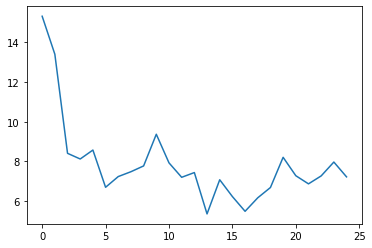

In [116]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [117]:
y_pred = rcnn_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_face_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 4.62% 
Balanced Accuracy: 16.01% 
ROC/AUC: 0.59 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.02


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

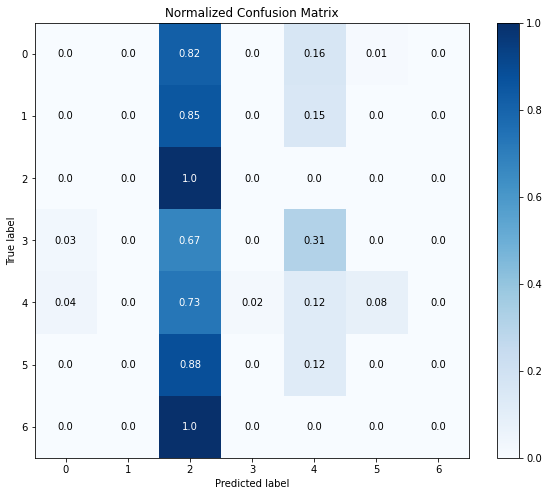

In [118]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

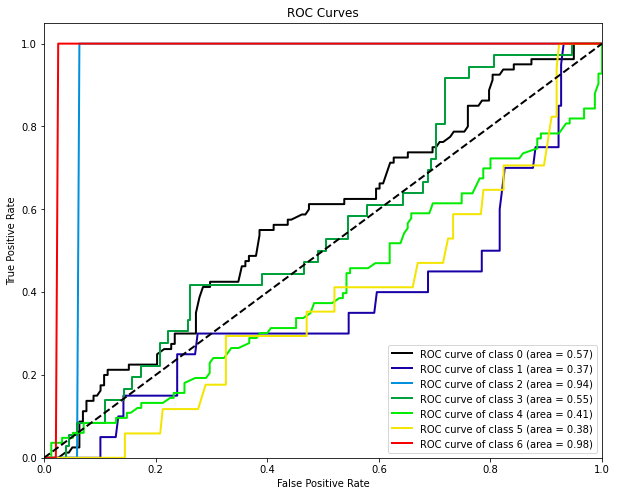

In [119]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

## 3. Multimodal Early Fusion

### Binary Classification

#### Dataset

In [30]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(782, 1, 350, 60) (782, 1)
(238, 1, 350, 60) (238, 1)


In [3]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### CNN + Bidirectional LSTM

In [4]:
class CNNLSTM():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='tanh'))(flatten)
        dense = Dense(64, activation='tanh')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

In [5]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

NameError: name 'X' is not defined

##### Prediction on the holdout set

In [15]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 58.40% 
ROC/AUC: 0.70 
Precision: 0.93 
Recall: 0.55 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

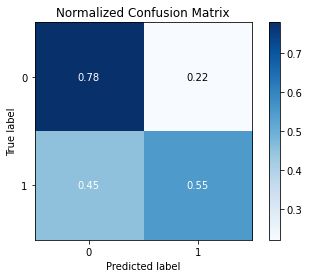

In [16]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

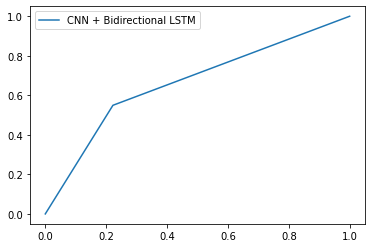

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

#### RCNN

In [18]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 1.2397 - accuracy: 0.5240 - auc_7: 0.5161 - precision_7: 0.5236 - recall_7: 0.7519 - f1_score: 0.6760 - val_loss: 0.9863 - val_accuracy: 0.4981 - val_auc_7: 0.5317 - val_precision_7: 0.4961 - val_recall_7: 0.9845 - val_f1_score: 0.6615 - 2s/epoch - 127ms/step
Epoch 2/25
17/17 - 1s - loss: 0.7417 - accuracy: 0.5681 - auc_7: 0.6119 - precision_7: 0.5584 - recall_7: 0.7368 - f1_score: 0.6760 - val_loss: 0.9200 - val_accuracy: 0.4904 - val_auc_7: 0.5026 - val_precision_7: 0.4921 - val_recall_7: 0.9612 - val_f1_score: 0.6667 - 749ms/epoch - 44ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7562 - accuracy: 0.5797 - auc_7: 0.6224 - precision_7: 0.5983 - recall_7: 0.5376 - f1_score: 0.6777 - val_loss: 0.9020 - val_accuracy: 0.5019 - val_auc_7: 0.5555 - val_precision_7: 0.4980 - val_recall_7: 0.9845 - val_f1_score: 0.6632 - 765ms/epoch - 45ms/step
Epoch 4/25
17/17 - 1s - loss: 0.7869 - accuracy: 0.5643 - auc_7: 0.6188 - precision_7: 0.5704 - recall_7: 0.5940 - f1_score: 0

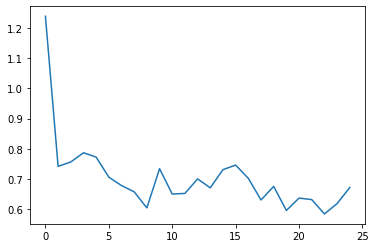

Epoch 1/25
17/17 - 2s - loss: 1.5527 - accuracy: 0.5278 - auc_8: 0.5212 - precision_8: 0.5357 - recall_8: 0.3488 - f1_score: 0.6624 - val_loss: 0.7973 - val_accuracy: 0.6360 - val_auc_8: 0.5148 - val_precision_8: 0.6400 - val_recall_8: 0.7007 - val_f1_score: 0.6851 - 2s/epoch - 117ms/step
Epoch 2/25
17/17 - 1s - loss: 0.8751 - accuracy: 0.5585 - auc_8: 0.5745 - precision_8: 0.5350 - recall_8: 0.8295 - f1_score: 0.6624 - val_loss: 0.7125 - val_accuracy: 0.5249 - val_auc_8: 0.5076 - val_precision_8: 0.5251 - val_recall_8: 0.9927 - val_f1_score: 0.6884 - 845ms/epoch - 50ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7474 - accuracy: 0.5681 - auc_8: 0.6155 - precision_8: 0.5696 - recall_8: 0.5233 - f1_score: 0.6624 - val_loss: 0.6928 - val_accuracy: 0.5249 - val_auc_8: 0.5214 - val_precision_8: 0.5251 - val_recall_8: 0.9927 - val_f1_score: 0.6884 - 763ms/epoch - 45ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6582 - accuracy: 0.5988 - auc_8: 0.6460 - precision_8: 0.5891 - recall_8: 0.6279 - f1_score: 0

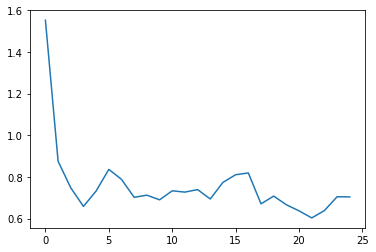

Epoch 1/25
17/17 - 2s - loss: 1.5470 - accuracy: 0.5115 - auc_9: 0.5445 - precision_9: 0.5249 - recall_9: 0.4361 - f1_score: 0.6751 - val_loss: 1.9139 - val_accuracy: 0.5000 - val_auc_9: 0.5490 - val_precision_9: 0.4981 - val_recall_9: 1.0000 - val_f1_score: 0.6632 - 2s/epoch - 109ms/step
Epoch 2/25
17/17 - 1s - loss: 0.8659 - accuracy: 0.5057 - auc_9: 0.5181 - precision_9: 0.5140 - recall_9: 0.5526 - f1_score: 0.6760 - val_loss: 1.6829 - val_accuracy: 0.4885 - val_auc_9: 0.5668 - val_precision_9: 0.1667 - val_recall_9: 0.0078 - val_f1_score: 0.6632 - 780ms/epoch - 46ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7746 - accuracy: 0.5498 - auc_9: 0.5941 - precision_9: 0.5544 - recall_9: 0.5940 - f1_score: 0.6751 - val_loss: 1.0356 - val_accuracy: 0.5885 - val_auc_9: 0.4999 - val_precision_9: 0.5696 - val_recall_9: 0.6977 - val_f1_score: 0.6632 - 692ms/epoch - 41ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6829 - accuracy: 0.5939 - auc_9: 0.6456 - precision_9: 0.6436 - recall_9: 0.4549 - f1_score: 0

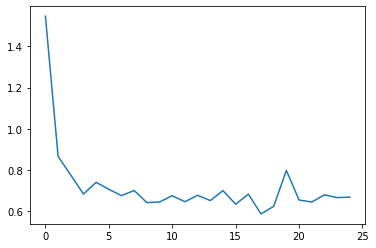

In [19]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [20]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 84.03% 
ROC/AUC: 0.54 
Precision: 0.86 
Recall: 0.98 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

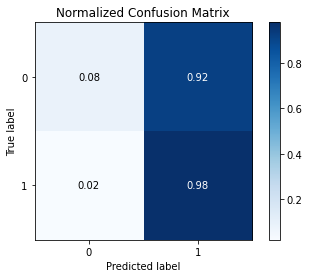

In [21]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

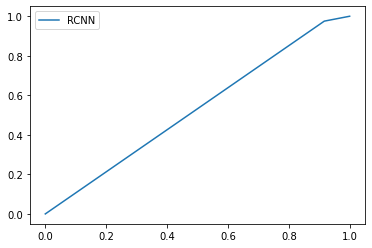

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

### Multiclass Classification

#### Dataset

In [23]:
X_train, X_test, y_train, y_test = load_fusioned_dataset()
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(782, 1, 350, 60) (782, 7)
(238, 1, 350, 60) (238, 7)


In [24]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### CNN + Bidirectional LSTM

In [25]:
class CNNLSTM():
    def __init__(self, n_length, n_features, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(512, activation='relu'))(flatten)
        dense = Dense(512, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 50s - loss: 505971.1875 - accuracy: 0.1689 - auc_11: 0.5165 - precision_11: 0.1689 - recall_11: 0.1689 - f1_score: 0.1142 - val_loss: 296423.8438 - val_accuracy: 0.0881 - val_auc_11: 0.4681 - val_precision_11: 0.0881 - val_recall_11: 0.0881 - val_f1_score: 0.0294 - 50s/epoch - 3s/step
Epoch 2/25
17/17 - 43s - loss: 336559.9375 - accuracy: 0.1555 - auc_11: 0.5074 - precision_11: 0.1555 - recall_11: 0.1555 - f1_score: 0.0728 - val_loss: 300913.4375 - val_accuracy: 0.0192 - val_auc_11: 0.4278 - val_precision_11: 0.0192 - val_recall_11: 0.0192 - val_f1_score: 0.0197 - 43s/epoch - 3s/step
Epoch 3/25
17/17 - 38s - loss: 553832.6250 - accuracy: 0.2054 - auc_11: 0.5380 - precision_11: 0.2054 - recall_11: 0.2054 - f1_score: 0.0858 - val_loss: 385758.9375 - val_accuracy: 0.4981 - val_auc_11: 0.7072 - val_precision_11: 0.4981 - val_recall_11: 0.4981 - val_f1_score: 0.0970 - 38s/epoch - 2s/step
Epoch 4/25
17/17 - 36s - loss: 262390.8438 - accuracy: 0.3455 - auc_11: 0.6191 - prec

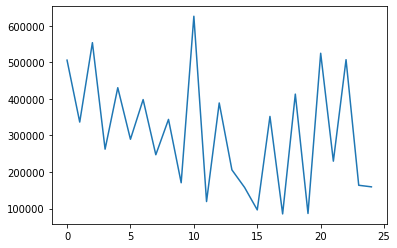

Epoch 1/25
17/17 - 42s - loss: 219458.2344 - accuracy: 0.2476 - auc_12: 0.5628 - precision_12: 0.2476 - recall_12: 0.2476 - f1_score: 0.1386 - val_loss: 244045.1250 - val_accuracy: 0.1149 - val_auc_12: 0.4837 - val_precision_12: 0.1149 - val_recall_12: 0.1149 - val_f1_score: 0.0311 - 42s/epoch - 2s/step
Epoch 2/25
17/17 - 34s - loss: 298072.8125 - accuracy: 0.1612 - auc_12: 0.5107 - precision_12: 0.1612 - recall_12: 0.1612 - f1_score: 0.0919 - val_loss: 177477.9844 - val_accuracy: 0.2069 - val_auc_12: 0.5374 - val_precision_12: 0.2069 - val_recall_12: 0.2069 - val_f1_score: 0.0508 - 34s/epoch - 2s/step
Epoch 3/25
17/17 - 28s - loss: 424292.5625 - accuracy: 0.3129 - auc_12: 0.5981 - precision_12: 0.3129 - recall_12: 0.3129 - f1_score: 0.1340 - val_loss: 179438.5781 - val_accuracy: 0.0881 - val_auc_12: 0.4681 - val_precision_12: 0.0881 - val_recall_12: 0.0881 - val_f1_score: 0.0247 - 28s/epoch - 2s/step
Epoch 4/25
17/17 - 32s - loss: 381212.7188 - accuracy: 0.1843 - auc_12: 0.5281 - prec

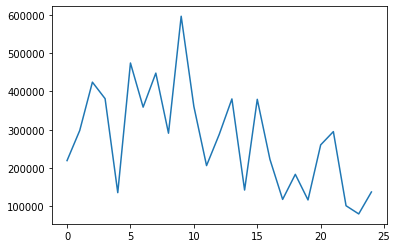

Epoch 1/25
17/17 - 43s - loss: 479724.4062 - accuracy: 0.1801 - auc_13: 0.5235 - precision_13: 0.1801 - recall_13: 0.1801 - f1_score: 0.1158 - val_loss: 116211.1719 - val_accuracy: 0.1385 - val_auc_13: 0.4974 - val_precision_13: 0.1385 - val_recall_13: 0.1385 - val_f1_score: 0.0364 - 43s/epoch - 3s/step
Epoch 2/25
17/17 - 33s - loss: 447413.9688 - accuracy: 0.2165 - auc_13: 0.5428 - precision_13: 0.2165 - recall_13: 0.2165 - f1_score: 0.1412 - val_loss: 65845.4375 - val_accuracy: 0.1077 - val_auc_13: 0.4795 - val_precision_13: 0.1077 - val_recall_13: 0.1077 - val_f1_score: 0.0306 - 33s/epoch - 2s/step
Epoch 3/25
17/17 - 32s - loss: 603541.6250 - accuracy: 0.2203 - auc_13: 0.5456 - precision_13: 0.2203 - recall_13: 0.2203 - f1_score: 0.1010 - val_loss: 25539.2656 - val_accuracy: 0.0962 - val_auc_13: 0.4722 - val_precision_13: 0.0962 - val_recall_13: 0.0962 - val_f1_score: 0.0519 - 32s/epoch - 2s/step
Epoch 4/25
17/17 - 30s - loss: 619172.8125 - accuracy: 0.1973 - auc_13: 0.5331 - precis

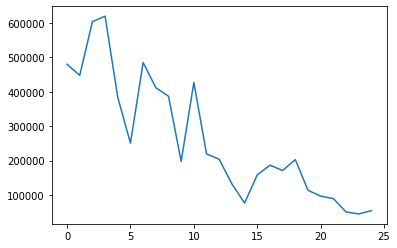

In [29]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_length, n_features, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [30]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 19.33% 
Balanced Accuracy: 17.77% 
ROC/AUC: 0.53 
Precision: 0.19 
Recall: 0.19 
F1 score: 0.12


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

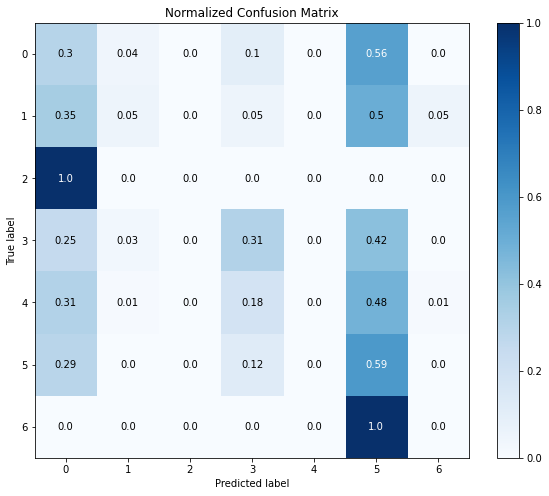

In [31]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

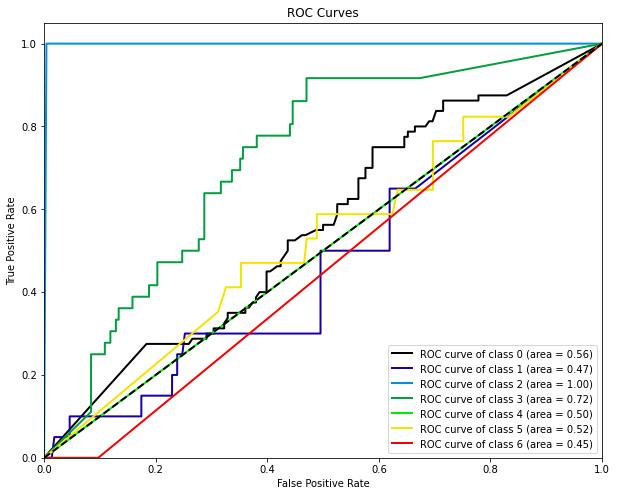

In [32]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

#### RCNN

In [33]:
class RCNN():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 19.2859 - accuracy: 0.1612 - auc_14: 0.5913 - precision_14: 0.1720 - recall_14: 0.0518 - f1_score: 0.1058 - val_loss: 2.9848 - val_accuracy: 0.2146 - val_auc_14: 0.5711 - val_precision_14: 0.4545 - val_recall_14: 0.0192 - val_f1_score: 0.0744 - 2s/epoch - 140ms/step
Epoch 2/25
17/17 - 1s - loss: 9.9537 - accuracy: 0.1919 - auc_14: 0.6220 - precision_14: 0.2318 - recall_14: 0.0672 - f1_score: 0.1451 - val_loss: 3.0739 - val_accuracy: 0.1992 - val_auc_14: 0.4859 - val_precision_14: 0.3636 - val_recall_14: 0.0153 - val_f1_score: 0.0544 - 775ms/epoch - 46ms/step
Epoch 3/25
17/17 - 1s - loss: 8.6793 - accuracy: 0.1324 - auc_14: 0.5884 - precision_14: 0.1825 - recall_14: 0.0441 - f1_score: 0.1117 - val_loss: 2.6498 - val_accuracy: 0.0805 - val_auc_14: 0.6046 - val_precision_14: 0.2727 - val_recall_14: 0.0115 - val_f1_score: 0.0253 - 788ms/epoch - 46ms/step
Epoch 4/25
17/17 - 1s - loss: 7.5932 - accuracy: 0.2860 - auc_14: 0.7199 - precision_14: 0.4219 - recall_14

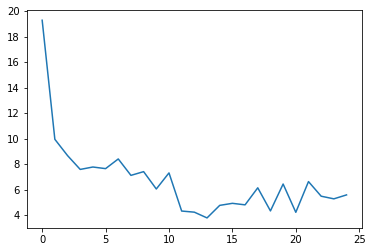

Epoch 1/25
17/17 - 2s - loss: 11.4607 - accuracy: 0.1401 - auc_15: 0.5842 - precision_15: 0.1019 - recall_15: 0.0307 - f1_score: 0.0889 - val_loss: 2.1852 - val_accuracy: 0.2069 - val_auc_15: 0.6898 - val_precision_15: 0.5000 - val_recall_15: 0.0077 - val_f1_score: 0.0596 - 2s/epoch - 144ms/step
Epoch 2/25
17/17 - 1s - loss: 5.6559 - accuracy: 0.3129 - auc_15: 0.6826 - precision_15: 0.2441 - recall_15: 0.0595 - f1_score: 0.1602 - val_loss: 2.7895 - val_accuracy: 0.1149 - val_auc_15: 0.5777 - val_precision_15: 0.2500 - val_recall_15: 0.0038 - val_f1_score: 0.0311 - 857ms/epoch - 50ms/step
Epoch 3/25
17/17 - 1s - loss: 5.2954 - accuracy: 0.1804 - auc_15: 0.6383 - precision_15: 0.3663 - recall_15: 0.0710 - f1_score: 0.1362 - val_loss: 2.4490 - val_accuracy: 0.0881 - val_auc_15: 0.6030 - val_precision_15: 0.2500 - val_recall_15: 0.0038 - val_f1_score: 0.0247 - 990ms/epoch - 58ms/step
Epoch 4/25
17/17 - 1s - loss: 6.2087 - accuracy: 0.1919 - auc_15: 0.6946 - precision_15: 0.3772 - recall_15

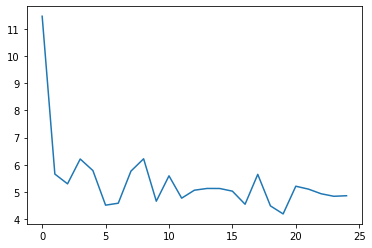

Epoch 1/25
17/17 - 2s - loss: 13.5931 - accuracy: 0.3199 - auc_16: 0.5613 - precision_16: 0.1667 - recall_16: 0.0536 - f1_score: 0.1450 - val_loss: 6.3811 - val_accuracy: 0.4923 - val_auc_16: 0.7529 - val_precision_16: 0.2000 - val_recall_16: 0.0038 - val_f1_score: 0.0945 - 2s/epoch - 121ms/step
Epoch 2/25
17/17 - 1s - loss: 12.0421 - accuracy: 0.3352 - auc_16: 0.6371 - precision_16: 0.2685 - recall_16: 0.0556 - f1_score: 0.1331 - val_loss: 3.3847 - val_accuracy: 0.2038 - val_auc_16: 0.6660 - val_precision_16: 0.4000 - val_recall_16: 0.0077 - val_f1_score: 0.0667 - 735ms/epoch - 43ms/step
Epoch 3/25
17/17 - 1s - loss: 9.3738 - accuracy: 0.1935 - auc_16: 0.5929 - precision_16: 0.2435 - recall_16: 0.0536 - f1_score: 0.1182 - val_loss: 2.7706 - val_accuracy: 0.0038 - val_auc_16: 0.5099 - val_precision_16: 0.2000 - val_recall_16: 0.0038 - val_f1_score: 0.0022 - 730ms/epoch - 43ms/step
Epoch 4/25
17/17 - 1s - loss: 6.3492 - accuracy: 0.0862 - auc_16: 0.5962 - precision_16: 0.3231 - recall_1

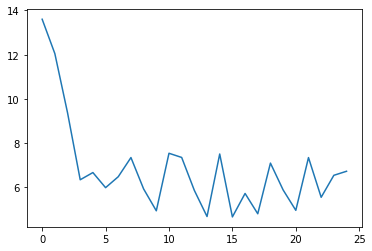

In [34]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [35]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 4.62% 
Balanced Accuracy: 16.23% 
ROC/AUC: 0.62 
Precision: 0.71 
Recall: 0.04 
F1 score: 0.04


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

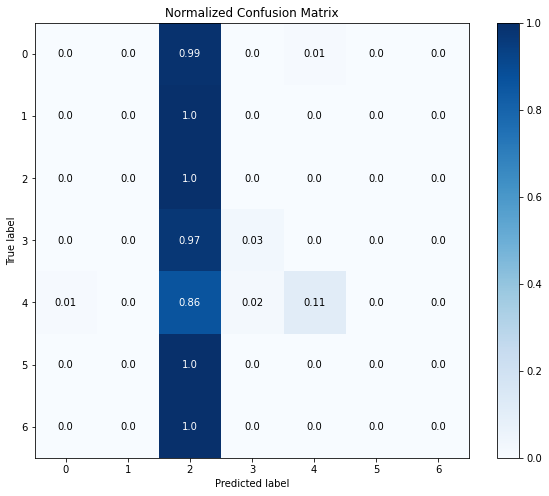

In [36]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

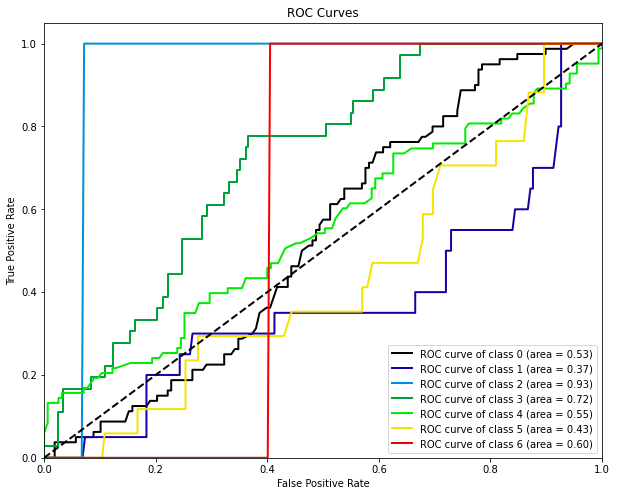

In [37]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

## 4. Multimodal Late Fusion

### Binary Classification

#### Dataset

In [4]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(782, 1, 350, 35) (782, 1)
(238, 1, 350, 35) (238, 1)


In [5]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


In [6]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

#### CNN + Bidirectional LSTM

In [14]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(256)(flatten_1)
        dense_1 = Dense(256, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(256)(flatten_2)
        dense_2 = Dense(256, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 13s - loss: 0.7827 - accuracy: 0.4837 - auc_3: 0.5267 - precision_3: 0.4870 - recall_3: 0.2105 - f1_score: 0.6760 - val_loss: 0.6898 - val_accuracy: 0.5364 - val_auc_3: 0.5713 - val_precision_3: 0.5206 - val_recall_3: 0.7829 - val_f1_score: 0.6615 - 13s/epoch - 742ms/step
Epoch 2/25
17/17 - 8s - loss: 0.6827 - accuracy: 0.5969 - auc_3: 0.6046 - precision_3: 0.6000 - recall_3: 0.6316 - f1_score: 0.6760 - val_loss: 0.6848 - val_accuracy: 0.5479 - val_auc_3: 0.5888 - val_precision_3: 0.5385 - val_recall_3: 0.5969 - val_f1_score: 0.6615 - 8s/epoch - 477ms/step
Epoch 3/25
17/17 - 8s - loss: 0.6782 - accuracy: 0.5931 - auc_3: 0.6285 - precision_3: 0.5844 - recall_3: 0.7030 - f1_score: 0.6760 - val_loss: 0.6844 - val_accuracy: 0.5479 - val_auc_3: 0.5898 - val_precision_3: 0.5379 - val_recall_3: 0.6047 - val_f1_score: 0.6615 - 8s/epoch - 473ms/step
Epoch 4/25
17/17 - 8s - loss: 0.6717 - accuracy: 0.6219 - auc_3: 0.6379 - precision_3: 0.6302 - recall_3: 0.6278 - f1_score: 0.6

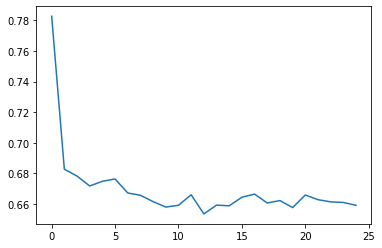

Epoch 1/25
17/17 - 16s - loss: 0.7302 - accuracy: 0.4664 - auc_4: 0.5012 - precision_4: 0.4780 - recall_4: 0.8411 - f1_score: 0.6624 - val_loss: 0.6921 - val_accuracy: 0.4674 - val_auc_4: 0.6236 - val_precision_4: 0.4286 - val_recall_4: 0.0438 - val_f1_score: 0.6884 - 16s/epoch - 919ms/step
Epoch 2/25
17/17 - 8s - loss: 0.6943 - accuracy: 0.5029 - auc_4: 0.5685 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.6624 - val_loss: 0.6902 - val_accuracy: 0.5096 - val_auc_4: 0.6229 - val_precision_4: 0.6286 - val_recall_4: 0.1606 - val_f1_score: 0.6884 - 8s/epoch - 486ms/step
Epoch 3/25
17/17 - 8s - loss: 0.6872 - accuracy: 0.5355 - auc_4: 0.5891 - precision_4: 0.5488 - recall_4: 0.3488 - f1_score: 0.6624 - val_loss: 0.6839 - val_accuracy: 0.5594 - val_auc_4: 0.6514 - val_precision_4: 0.5462 - val_recall_4: 0.9489 - val_f1_score: 0.6884 - 8s/epoch - 460ms/step
Epoch 4/25
17/17 - 9s - loss: 0.6864 - accuracy: 0.5489 - auc_4: 0.5746 - precision_4: 0.5455 - recall_4: 0.5349 - f1_sc

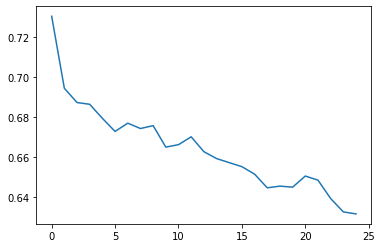

Epoch 1/25
17/17 - 12s - loss: 0.7078 - accuracy: 0.4981 - auc_5: 0.5310 - precision_5: 0.5109 - recall_5: 0.3534 - f1_score: 0.6751 - val_loss: 0.6787 - val_accuracy: 0.6115 - val_auc_5: 0.6958 - val_precision_5: 0.5778 - val_recall_5: 0.8062 - val_f1_score: 0.6632 - 12s/epoch - 697ms/step
Epoch 2/25
17/17 - 7s - loss: 0.6800 - accuracy: 0.5900 - auc_5: 0.6212 - precision_5: 0.5707 - recall_5: 0.7895 - f1_score: 0.6751 - val_loss: 0.6782 - val_accuracy: 0.6423 - val_auc_5: 0.6797 - val_precision_5: 0.7195 - val_recall_5: 0.4574 - val_f1_score: 0.6632 - 7s/epoch - 430ms/step
Epoch 3/25
17/17 - 7s - loss: 0.6793 - accuracy: 0.6015 - auc_5: 0.6192 - precision_5: 0.6107 - recall_5: 0.6015 - f1_score: 0.6751 - val_loss: 0.6650 - val_accuracy: 0.6615 - val_auc_5: 0.7136 - val_precision_5: 0.6723 - val_recall_5: 0.6202 - val_f1_score: 0.6632 - 7s/epoch - 426ms/step
Epoch 4/25
17/17 - 7s - loss: 0.6702 - accuracy: 0.6284 - auc_5: 0.6691 - precision_5: 0.6071 - recall_5: 0.7669 - f1_score: 0.6

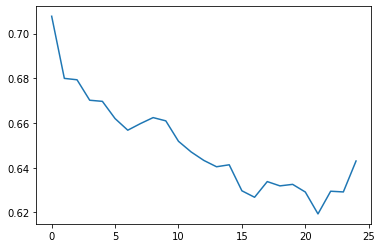

In [15]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [17]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 60.50% 
ROC/AUC: 0.69 
Precision: 0.92 
Recall: 0.59 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

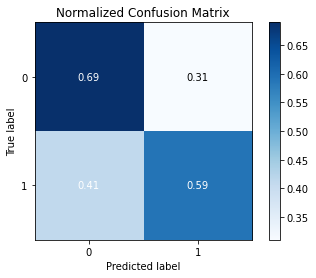

In [18]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(body_y_test, y_pred, normalize=True)

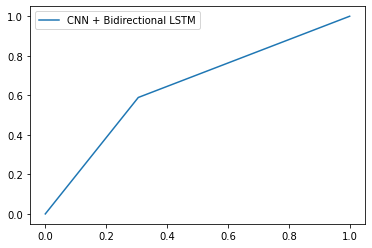

In [19]:
fpr, tpr, _ = roc_curve(body_y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

#### RCNN

In [24]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(256)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(256)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 3s - loss: 1.8311 - accuracy: 0.6219 - auc_8: 0.6477 - precision_8: 0.6255 - recall_8: 0.6466 - f1_score: 0.6760 - val_loss: 36.6934 - val_accuracy: 0.4981 - val_auc_8: 0.5038 - val_precision_8: 0.4962 - val_recall_8: 1.0000 - val_f1_score: 0.6615 - 3s/epoch - 180ms/step
Epoch 2/25
17/17 - 1s - loss: 1.5981 - accuracy: 0.6142 - auc_8: 0.6626 - precision_8: 0.6265 - recall_8: 0.6053 - f1_score: 0.6760 - val_loss: 2.3377 - val_accuracy: 0.6054 - val_auc_8: 0.6306 - val_precision_8: 0.7241 - val_recall_8: 0.3256 - val_f1_score: 0.6684 - 1s/epoch - 82ms/step
Epoch 3/25
17/17 - 1s - loss: 1.2305 - accuracy: 0.6449 - auc_8: 0.6937 - precision_8: 0.6588 - recall_8: 0.6316 - f1_score: 0.6768 - val_loss: 22.5552 - val_accuracy: 0.4943 - val_auc_8: 0.5000 - val_precision_8: 0.4943 - val_recall_8: 1.0000 - val_f1_score: 0.6615 - 1s/epoch - 65ms/step
Epoch 4/25
17/17 - 1s - loss: 2.0836 - accuracy: 0.6219 - auc_8: 0.6656 - precision_8: 0.6245 - recall_8: 0.6504 - f1_score: 0.674

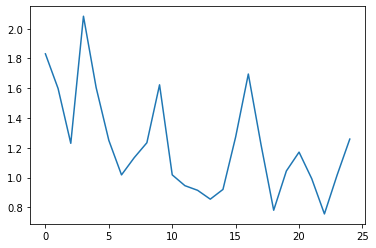

Epoch 1/25
17/17 - 3s - loss: 2.7083 - accuracy: 0.5643 - auc_9: 0.5746 - precision_9: 0.5618 - recall_9: 0.5465 - f1_score: 0.6606 - val_loss: 21.8489 - val_accuracy: 0.5211 - val_auc_9: 0.4967 - val_precision_9: 0.5233 - val_recall_9: 0.9854 - val_f1_score: 0.6869 - 3s/epoch - 154ms/step
Epoch 2/25
17/17 - 1s - loss: 1.3551 - accuracy: 0.6891 - auc_9: 0.7328 - precision_9: 0.6832 - recall_9: 0.6938 - f1_score: 0.6632 - val_loss: 12.1302 - val_accuracy: 0.5287 - val_auc_9: 0.5004 - val_precision_9: 0.5269 - val_recall_9: 1.0000 - val_f1_score: 0.6884 - 1s/epoch - 65ms/step
Epoch 3/25
17/17 - 1s - loss: 1.6341 - accuracy: 0.6468 - auc_9: 0.6856 - precision_9: 0.6480 - recall_9: 0.6279 - f1_score: 0.6606 - val_loss: 2.7723 - val_accuracy: 0.5402 - val_auc_9: 0.6155 - val_precision_9: 0.5350 - val_recall_9: 0.9489 - val_f1_score: 0.6869 - 1s/epoch - 64ms/step
Epoch 4/25
17/17 - 1s - loss: 1.5246 - accuracy: 0.6296 - auc_9: 0.6744 - precision_9: 0.6182 - recall_9: 0.6589 - f1_score: 0.664

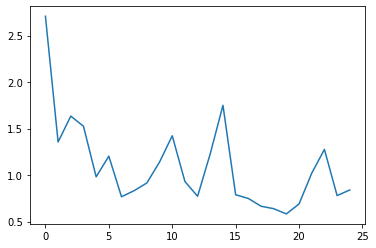

Epoch 1/25
17/17 - 3s - loss: 2.3199 - accuracy: 0.5613 - auc_10: 0.5747 - precision_10: 0.5709 - recall_10: 0.5602 - f1_score: 0.6718 - val_loss: 14.6241 - val_accuracy: 0.5038 - val_auc_10: 0.5001 - val_precision_10: 0.5000 - val_recall_10: 0.0078 - val_f1_score: 0.5462 - 3s/epoch - 151ms/step
Epoch 2/25
17/17 - 1s - loss: 1.5312 - accuracy: 0.5862 - auc_10: 0.6368 - precision_10: 0.5962 - recall_10: 0.5827 - f1_score: 0.6777 - val_loss: 3.4825 - val_accuracy: 0.5308 - val_auc_10: 0.5865 - val_precision_10: 0.5660 - val_recall_10: 0.2326 - val_f1_score: 0.6649 - 1s/epoch - 62ms/step
Epoch 3/25
17/17 - 1s - loss: 1.9156 - accuracy: 0.6092 - auc_10: 0.6539 - precision_10: 0.6140 - recall_10: 0.6278 - f1_score: 0.6812 - val_loss: 2.3092 - val_accuracy: 0.6038 - val_auc_10: 0.6600 - val_precision_10: 0.6912 - val_recall_10: 0.3643 - val_f1_score: 0.6649 - 1s/epoch - 61ms/step
Epoch 4/25
17/17 - 1s - loss: 1.3164 - accuracy: 0.6360 - auc_10: 0.6961 - precision_10: 0.6532 - recall_10: 0.60

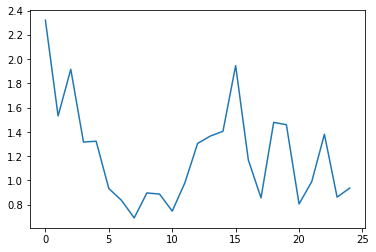

In [25]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [26]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 52.52% 
ROC/AUC: 0.64 
Precision: 0.89 
Recall: 0.50 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

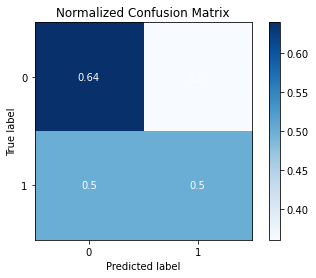

In [27]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(body_y_test, y_pred, normalize=True)

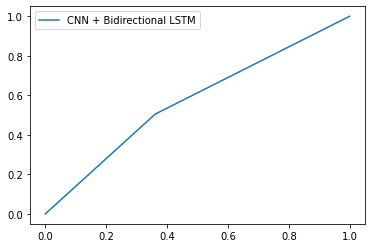

In [28]:
fpr, tpr, _ = roc_curve(body_y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

#### Ensemble

In [29]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return

In [64]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [65]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [66]:
dirichletEnsemble.describe()

CNN + Bidirectional LSTM Body Model (weight: 0.3390)
RCNN Body Model (weight: 0.0051)
CNN + Bidirectional LSTM Face Model (weight: 0.0015)
RCNN Face Model (weight: 0.6544)
Accuracy: 100.00% - ROC/AUC: 0.68 - Precision: 1.00 - Recall: 1.00 - F1 score: 1.00


### Multiclass Classification

#### Dataset

In [67]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(782, 1, 350, 35) (782, 7)
(238, 1, 350, 35) (238, 7)


In [68]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs')
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(782, 1, 350, 25) (782, 7)
(238, 1, 350, 25) (238, 7)


In [69]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

#### CNN + Bidirectional LSTM

In [71]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(256)(flatten_1)
        dense_1 = Dense(256, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(256)(flatten_2)
        dense_2 = Dense(256, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 12s - loss: 10.8595 - accuracy: 0.0691 - auc_30: 0.5858 - precision_30: 0.0323 - recall_30: 0.0019 - f1_score: 0.0305 - val_loss: 1.6876 - val_accuracy: 0.0805 - val_auc_30: 0.6240 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.0213 - 12s/epoch - 687ms/step
Epoch 2/25
17/17 - 7s - loss: 9.4391 - accuracy: 0.0729 - auc_30: 0.6484 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - f1_score: 0.0352 - val_loss: 1.7141 - val_accuracy: 0.0690 - val_auc_30: 0.6872 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.0185 - 7s/epoch - 423ms/step
Epoch 3/25
17/17 - 7s - loss: 8.8626 - accuracy: 0.2073 - auc_30: 0.7143 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - f1_score: 0.0764 - val_loss: 1.7335 - val_accuracy: 0.0690 - val_auc_30: 0.7152 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.0184 - 7s/epoch - 420ms/step
Epoch 4/25
17/17 - 7s - loss: 8.6146 - accuracy: 0.1075 - auc_30: 0.7

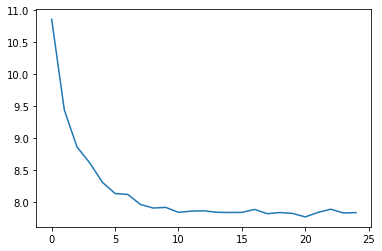

Epoch 1/25
17/17 - 13s - loss: 6.1277 - accuracy: 0.1478 - auc_31: 0.6858 - precision_31: 0.1250 - recall_31: 0.0077 - f1_score: 0.0867 - val_loss: 1.6277 - val_accuracy: 0.2031 - val_auc_31: 0.7699 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.0482 - 13s/epoch - 758ms/step
Epoch 2/25
17/17 - 8s - loss: 5.5556 - accuracy: 0.2649 - auc_31: 0.7438 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - f1_score: 0.0875 - val_loss: 1.6211 - val_accuracy: 0.4483 - val_auc_31: 0.7813 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.1086 - 8s/epoch - 464ms/step
Epoch 3/25
17/17 - 8s - loss: 5.3963 - accuracy: 0.3532 - auc_31: 0.7672 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - f1_score: 0.1338 - val_loss: 1.6962 - val_accuracy: 0.1149 - val_auc_31: 0.6334 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.0295 - 8s/epoch - 445ms/step
Epoch 4/25
17/17 - 7s - loss: 5.3274 - accuracy: 0.1286 - auc_31: 0.62

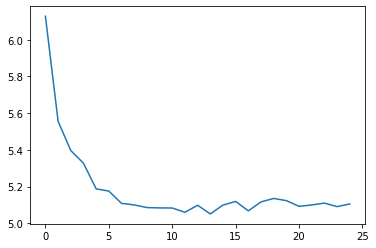

Epoch 1/25
17/17 - 16s - loss: 9.4623 - accuracy: 0.3046 - auc_32: 0.6575 - precision_32: 0.0000e+00 - recall_32: 0.0000e+00 - f1_score: 0.0992 - val_loss: 1.6230 - val_accuracy: 0.5038 - val_auc_32: 0.7659 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.0957 - 16s/epoch - 929ms/step
Epoch 2/25
17/17 - 8s - loss: 8.4809 - accuracy: 0.2146 - auc_32: 0.7254 - precision_32: 0.0000e+00 - recall_32: 0.0000e+00 - f1_score: 0.0738 - val_loss: 1.6754 - val_accuracy: 0.0692 - val_auc_32: 0.6966 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.0185 - 8s/epoch - 488ms/step
Epoch 3/25
17/17 - 8s - loss: 8.0878 - accuracy: 0.2107 - auc_32: 0.7344 - precision_32: 0.0000e+00 - recall_32: 0.0000e+00 - f1_score: 0.0844 - val_loss: 1.6844 - val_accuracy: 0.1885 - val_auc_32: 0.7645 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.0453 - 8s/epoch - 443ms/step
Epoch 4/25
17/17 - 8s - loss: 7.8299 - accuracy: 0.3678 - auc_

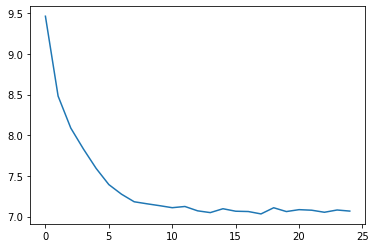

In [78]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [79]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 0.42% 
Balanced Accuracy: 14.29% 
ROC/AUC: 0.59 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.00


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

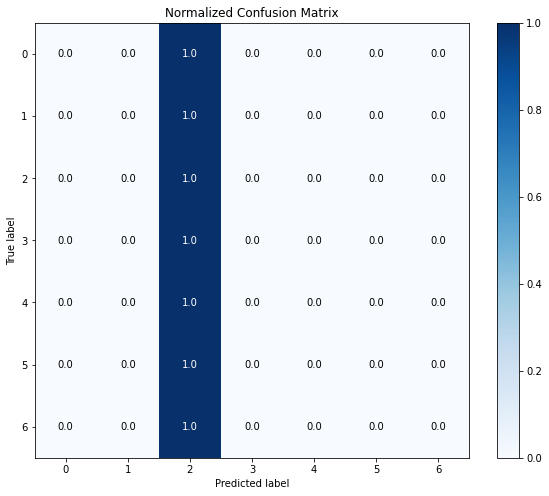

In [80]:
skplt.metrics.plot_confusion_matrix(body_y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

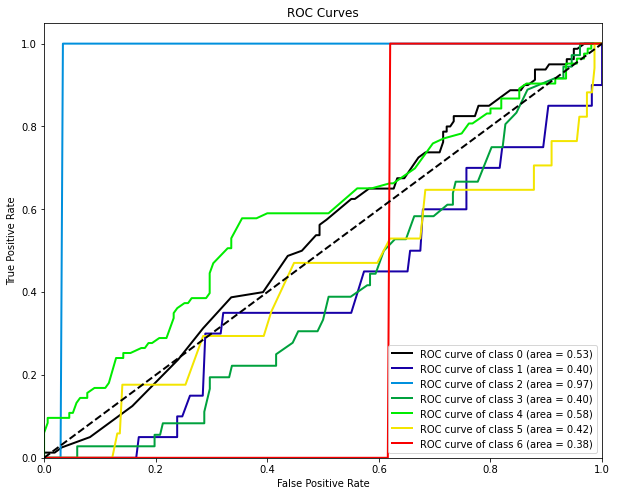

In [81]:
skplt.metrics.plot_roc(body_y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

#### RCNN

In [84]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(256)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(256)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 3s - loss: 39.9144 - accuracy: 0.2092 - auc_34: 0.6294 - precision_34: 0.2033 - recall_34: 0.1420 - f1_score: 0.1287 - val_loss: 49.1000 - val_accuracy: 0.0766 - val_auc_34: 0.4448 - val_precision_34: 0.0766 - val_recall_34: 0.0766 - val_f1_score: 0.0267 - 3s/epoch - 162ms/step
Epoch 2/25
17/17 - 1s - loss: 13.8220 - accuracy: 0.2591 - auc_34: 0.6334 - precision_34: 0.2683 - recall_34: 0.2246 - f1_score: 0.1808 - val_loss: 42.7623 - val_accuracy: 0.0805 - val_auc_34: 0.4636 - val_precision_34: 0.0805 - val_recall_34: 0.0805 - val_f1_score: 0.0274 - 1s/epoch - 68ms/step
Epoch 3/25
17/17 - 1s - loss: 10.4022 - accuracy: 0.3608 - auc_34: 0.7287 - precision_34: 0.3857 - recall_34: 0.3013 - f1_score: 0.3876 - val_loss: 17.6089 - val_accuracy: 0.0958 - val_auc_34: 0.4790 - val_precision_34: 0.0958 - val_recall_34: 0.0958 - val_f1_score: 0.0304 - 1s/epoch - 67ms/step
Epoch 4/25
17/17 - 1s - loss: 6.9825 - accuracy: 0.3417 - auc_34: 0.7506 - precision_34: 0.3463 - recall_34:

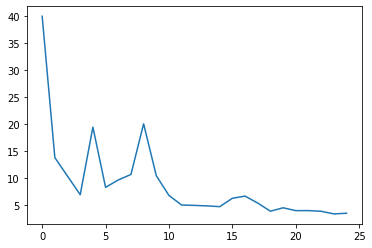

Epoch 1/25
17/17 - 3s - loss: 18.5889 - accuracy: 0.2514 - auc_35: 0.6417 - precision_35: 0.2506 - recall_35: 0.1939 - f1_score: 0.1652 - val_loss: 67.1131 - val_accuracy: 0.1111 - val_auc_35: 0.4764 - val_precision_35: 0.1111 - val_recall_35: 0.1111 - val_f1_score: 0.0291 - 3s/epoch - 157ms/step
Epoch 2/25
17/17 - 1s - loss: 9.8069 - accuracy: 0.2975 - auc_35: 0.6803 - precision_35: 0.3093 - recall_35: 0.2553 - f1_score: 0.2057 - val_loss: 25.5549 - val_accuracy: 0.1226 - val_auc_35: 0.4778 - val_precision_35: 0.1226 - val_recall_35: 0.1226 - val_f1_score: 0.0597 - 1s/epoch - 63ms/step
Epoch 3/25
17/17 - 1s - loss: 7.9943 - accuracy: 0.3762 - auc_35: 0.7588 - precision_35: 0.3903 - recall_35: 0.3244 - f1_score: 0.2814 - val_loss: 19.4530 - val_accuracy: 0.0881 - val_auc_35: 0.4734 - val_precision_35: 0.0881 - val_recall_35: 0.0881 - val_f1_score: 0.0251 - 1s/epoch - 63ms/step
Epoch 4/25
17/17 - 1s - loss: 7.1900 - accuracy: 0.4050 - auc_35: 0.7814 - precision_35: 0.4188 - recall_35: 0

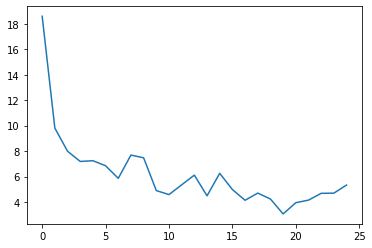

Epoch 1/25
17/17 - 3s - loss: 20.6907 - accuracy: 0.2011 - auc_36: 0.6415 - precision_36: 0.1662 - recall_36: 0.1054 - f1_score: 0.1407 - val_loss: 27.5604 - val_accuracy: 0.1577 - val_auc_36: 0.5105 - val_precision_36: 0.1577 - val_recall_36: 0.1577 - val_f1_score: 0.0735 - 3s/epoch - 160ms/step
Epoch 2/25
17/17 - 1s - loss: 36.7613 - accuracy: 0.2567 - auc_36: 0.6937 - precision_36: 0.2551 - recall_36: 0.1916 - f1_score: 0.2072 - val_loss: 24.4824 - val_accuracy: 0.1423 - val_auc_36: 0.4990 - val_precision_36: 0.1423 - val_recall_36: 0.1423 - val_f1_score: 0.0568 - 1s/epoch - 63ms/step
Epoch 3/25
17/17 - 1s - loss: 17.8331 - accuracy: 0.2299 - auc_36: 0.6200 - precision_36: 0.2186 - recall_36: 0.1801 - f1_score: 0.2363 - val_loss: 31.0308 - val_accuracy: 0.0692 - val_auc_36: 0.4470 - val_precision_36: 0.0692 - val_recall_36: 0.0692 - val_f1_score: 0.0447 - 1s/epoch - 63ms/step
Epoch 4/25
17/17 - 1s - loss: 18.8542 - accuracy: 0.2720 - auc_36: 0.6427 - precision_36: 0.2754 - recall_36

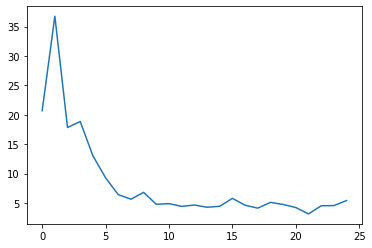

In [85]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [86]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 22.27% 
Balanced Accuracy: 18.66% 
ROC/AUC: 0.62 
Precision: 0.22 
Recall: 0.18 
F1 score: 0.13


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

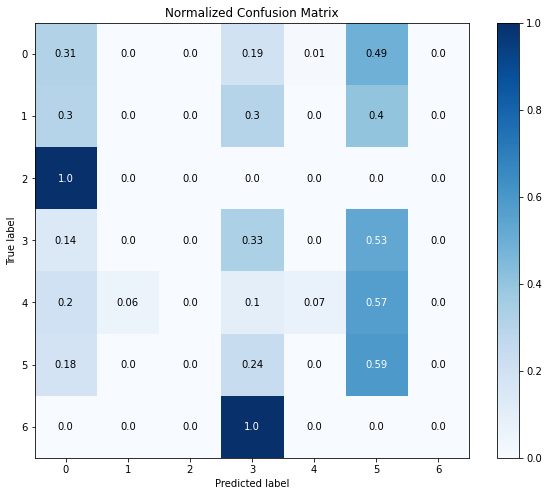

In [87]:
skplt.metrics.plot_confusion_matrix(body_y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

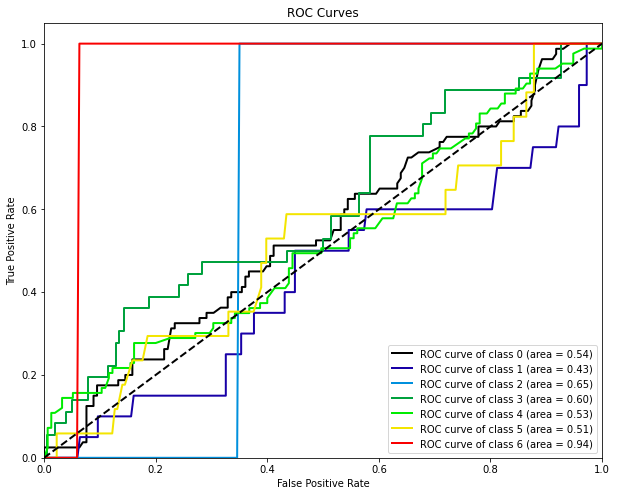

In [88]:
skplt.metrics.plot_roc(body_y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

#### Ensemble

In [148]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

ValueError: in user code:

    File "/Users/mnktech/.local/share/virtualenvs/masters-thesis-dSEc-4wZ/lib/python3.9/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/Users/mnktech/.local/share/virtualenvs/masters-thesis-dSEc-4wZ/lib/python3.9/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mnktech/.local/share/virtualenvs/masters-thesis-dSEc-4wZ/lib/python3.9/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/mnktech/.local/share/virtualenvs/masters-thesis-dSEc-4wZ/lib/python3.9/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/Users/mnktech/.local/share/virtualenvs/masters-thesis-dSEc-4wZ/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/mnktech/.local/share/virtualenvs/masters-thesis-dSEc-4wZ/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_54" is incompatible with the layer: expected shape=(None, 1, 350, 25), found shape=(None, 1, 350, 35)


In [ ]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [ ]:
dirichletEnsemble.describe()